In [1]:
import numpy as np
import math
import pandas as pd
import cv2
import os
#import tqdm
#from scipy.io import loadmat

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from PIL import Image
# import pytesseract

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

# from utils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.layers import *

# from keras.applications import MobileNetV2
# from keras.applications import InceptionResNetV2

from keras.models import Model
from keras.models import model_from_json
from keras import regularizers

#from keras.initializers import he_normal


In [2]:
target_size = [608, 608]
target_w = 608 # target sizes of image in model input
target_h = 608 #target sizes of image in model input

class_num = 1     ## item

categories = ['bom'] # details of classes

In [6]:
num_image_folder = []
drg_image = []

for i in range(1, 28):
    drg_folder = 'drg_test_' + str(i)
    drg_directory = '/Users/subrata/workstation/jupyterFiles/yolo_data_file/' + drg_folder
    inter_var_1 = drg_directory + '/{}'
    drg_folder = [inter_var_1.format(i) for i in os.listdir(drg_directory)]
    num_image_folder.append(len(drg_folder))
    drg_image.append(drg_folder)

print('Number of images in folders = ', num_image_folder)

num_images = len(drg_image)

print('Number of image folders = ', num_images)


Number of images in folders =  [36, 36, 36, 42, 36, 41, 35, 54, 54, 40, 106, 54, 61, 53, 98, 97, 95, 99, 12, 32, 45, 45, 45, 47, 46, 66, 58]
Number of image folders =  27


In [7]:
## drg_image above is a list of lists. We need to flatten this : 

from itertools import chain

k = list(chain.from_iterable(map(list, drg_image)))
drg_image = k
drg_image.sort() # Sorting the list

print(len(drg_image))

1469


In [14]:
drg_image[0]

'/Users/subrata/workstation/jupyterFiles/yolo_data_file/drg_test_1/1001.jpg'

In [90]:
# Check sizes of exiting images & Create a Dataframe with image id and height(row) and width(column):

rows = []
columns = []
image_sl = []
df_image_size = pd.DataFrame()

for i in range(len(drg_image)):
    image = cv2.imread(drg_image[i]) ## Loading image
    
    
    height, width, _ = image.shape
    rows.append(height)
    columns.append(width)
    image_sl.append(drg_image[i])
print(len(rows))      
row_values = pd.Series(rows)
col_values = pd.Series(columns)
image_num = pd.Series(image_sl)


df_image_size.insert(loc=0, column='image_serial', value=image_num)
df_image_size.insert(loc=1, column='rows', value=row_values)
df_image_size.insert(loc=2, column='columns', value=col_values)

df_image_size.tail(3)

1469


image_serial  rows  columns
1466  /Users/subrata/workstation/jupyterFiles/yolo_d...  1240     1754
1467  /Users/subrata/workstation/jupyterFiles/yolo_d...  1240     1754
1468  /Users/subrata/workstation/jupyterFiles/yolo_d...  1240     1754

In [91]:

# Loading output of VGG Image Annotation tool and create a dataframe

region_data = []

for i in range(1, 28):
    via_folder = '/Users/subrata/workstation/jupyterFiles/yolo_data_file/via_region_data_drg_test_' + str(i) + '.csv'
    region = pd.read_csv(via_folder)
    region_data.append(region)
    
r_data = pd.concat(region_data)

# Create data_master having bbox information :

r_data_master = r_data[~r_data['region_shape_attributes'].str.contains('{}')].reset_index(drop=True)
r_data_master_unique = r_data_master.drop_duplicates('#filename', keep=False).reset_index(drop=True)
r_data_master_unique.drop(r_data_master_unique.columns[[1, 2, 3, 4]], axis=1, inplace=True) # reduce unnecessary columns
num_images_in_data_master = r_data_master_unique["#filename"].nunique()
r_data_master_image_list = r_data_master_unique["#filename"].tolist()


# Create drg master having bbox information :

reqd_drg_image = []
k = 0

for i in r_data_master_image_list:

    # print(i)
    image_desc = [s for s in drg_image if i in s]
    # print(image_desc)

    if image_desc != []:
        reqd_drg_image.append(image_desc)

    if image_desc == []:
        r_data_master_unique = r_data_master_unique[r_data_master_unique['#filename'] != i]

 #   reqd_drg_image.append(image_desc)
 #   print(reqd_drg_image[k])
    # print('*************************')
 #   k=k+1

r_data_master_unique = r_data_master_unique.reset_index(drop = 'True')
print(len(r_data))         # all data including drgs with no bbox data
print(len(r_data_master))  # data with drgs having bbox information

print(len(r_data_master_unique))
print(len(r_data_master_image_list))

print(num_images_in_data_master)
print(len(drg_image))      # all drg images
print(len(reqd_drg_image)) # drgs having bbox information



1470
1461
1432
1435
1435
1469
1432


In [10]:
pd.DataFrame(reqd_drg_image).head(5)

0
0  /Users/subrata/workstation/jupyterFiles/yolo_d...
1  /Users/subrata/workstation/jupyterFiles/yolo_d...
2  /Users/subrata/workstation/jupyterFiles/yolo_d...
3  /Users/subrata/workstation/jupyterFiles/yolo_d...
4  /Users/subrata/workstation/jupyterFiles/yolo_d...

In [62]:
# writing to Excel

# out_path = "C:\\Users\\Bala\\output\\temp-excel.xlsx"
# out_path = "C:/Users/subrata/Desktop/temp-excel.xlsx"
out_path = "/Users/subrata/workstation/jupyterFiles/yolo_data_file/temp_xl.xlsx"
# out_path = "temp-excel.xlsx"
# writer = pd.ExcelWriter(out_path , engine='xlsxwriter')
# df.to_excel(writer, sheet_name='Sheet1')
# writer.save()


r_d_m_u = pd.ExcelWriter(out_path)
  
# write DataFrame to excel
r_data_master_unique.to_excel(r_d_m_u)
  
# save the excel
r_d_m_u.save()

o_path = "/Users/subrata/workstation/jupyterFiles/yolo_data_file/temp_xl_1.xlsx"
image_list = pd.ExcelWriter(o_path)
pd.DataFrame(reqd_drg_image).to_excel(image_list)
image_list.save()


/var/folders/_y/wjshqn7x7lgf5rrlggyz8j3r0000gp/T/ipykernel_61542/877504808.py:18: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  r_d_m_u.save()
/var/folders/_y/wjshqn7x7lgf5rrlggyz8j3r0000gp/T/ipykernel_61542/877504808.py:23: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  image_list.save()


In [93]:
# Check sizes of exiting images & Create a Dataframe with image id and height(row) and width(column):

rows = []
columns = []
image_sl = []
df_image_size = pd.DataFrame()

for i in range(len(reqd_drg_image)):
 #   print(i)
    image = cv2.imread(reqd_drg_image[i][0]) ## Loading image
    
    height, width, _ = image.shape
    rows.append(height)
    columns.append(width)
    image_sl.append(reqd_drg_image[i][0])
print(len(rows))      
row_values = pd.Series(rows)
col_values = pd.Series(columns)
image_num = pd.Series(image_sl)


df_image_size.insert(loc=0, column='image_serial', value=image_num)
df_image_size.insert(loc=1, column='rows', value=row_values)
df_image_size.insert(loc=2, column='columns', value=col_values)

df_image_size.tail(3)

1432


image_serial  rows  columns
1429  /Users/subrata/workstation/jupyterFiles/yolo_d...  2479     3508
1430  /Users/subrata/workstation/jupyterFiles/yolo_d...  2479     3508
1431  /Users/subrata/workstation/jupyterFiles/yolo_d...  2479     3508

In [94]:
# Making a dataframe for Image_id, x, y, width, height, class, image_width and image_height

x = []  # co-ordinate of bbox left-top corner and NOT center of bbox
y = []  # co-ordinate of bbox left-top corner and NOT center of bbox
width = []
height = []
obj_class = []
i_width = []
i_height = []
img_path = []
img_index = []

for i in range(len(r_data_master_unique)):
    
    r_size = r_data_master_unique.values[i, 1][1:(len(r_data_master_unique.values[i, 1])-1)]
    r_size_par = r_size.split(",")
    
    # print(i)
    
    x.append(int("".join(filter(str.isdigit, r_size_par[1]))))
#    print('=================================================')
    y.append(int("".join(filter(str.isdigit, r_size_par[2]))))
    width.append(int("".join(filter(str.isdigit, r_size_par[3]))))
    height.append(int("".join(filter(str.isdigit, r_size_par[4]))))
    
    r_attribs = r_data_master_unique.values[i, 2][1:(len(r_data_master_unique.values[i, 2])-1)]

    # if i == 1051:
    #    print('r_attribs=', r_attribs)

    if len(r_attribs) == 0 :
        obj_class.append('nil')
    elif len(r_attribs) == 8 :
        r_attribs_par = r_attribs.split(':')[0]
        obj_class.append(r_attribs_par[1:(len(r_attribs_par)-1)])
    else :
        r_attribs_par = r_attribs.split(':')[1]
        obj_class.append(r_attribs_par[1:(len(r_attribs_par)-1)])
    
    foto_id = r_data_master_unique['#filename'][i]

    # print(foto_id)

    final_image_list = df_image_size['image_serial'].to_list()
    # flat_image_list = [item for sublist in final_image_list for item in sublist]
    # print(final_image_list[0])
    i_path = [s for s in final_image_list if foto_id in s]
    # foto_index = [idx for idx, s in enumerate(final_image_list[:][0]) if foto_id in s][0]
    foto_index = [idx for idx, s in enumerate(final_image_list) if foto_id in s][0]
    

    # print(i)
    # print(i_path)
    # print(type(i_path))
    # print(i_path[0])
    # print(len(i_path))
    # print(foto_index)


    # print('====================================')
    
    
    foto_width = df_image_size['columns'][foto_index]
    foto_height = df_image_size['rows'][foto_index]
    i_width.append(foto_width)
    i_height.append(foto_height)
    img_path.append(i_path)
    img_index.append(foto_index)
    
x_values = pd.Series(x)
y_values = pd.Series(y)
width_values = pd.Series(width)
height_values = pd.Series(height)
class_values = pd.Series(obj_class)
i_width_values = pd.Series(i_width)
i_height_values = pd.Series(i_height)
img_path_values = pd.Series(img_path)
img_index_values = pd.Series(img_index)

r_data_master_unique.insert(loc=1, column='img_idx', value=img_index_values)
r_data_master_unique.insert(loc=2, column='i_path', value=img_path_values)
r_data_master_unique.insert(loc=3, column='x', value=x_values)
r_data_master_unique.insert(loc=4, column='y', value=y_values)
r_data_master_unique.insert(loc=5, column='width', value=width_values)
r_data_master_unique.insert(loc=6, column='height', value=height_values)
r_data_master_unique.insert(loc=7, column='obj_class', value=class_values)
r_data_master_unique.insert(loc=8, column='img_wd', value=i_width_values)
r_data_master_unique.insert(loc=9, column='img_ht', value=i_height_values)

r_data_master_unique.drop(r_data_master_unique.columns[[10, 11]], axis=1, inplace=True) # reduce unnecessary columns

r_data_master_unique.rename({'#filename': 'img_id'}, axis=1, inplace=True) # changing column name

num_images = len(r_data_master_unique)
print(num_images)

r_data_master_unique.tail(3)


1432


img_id  img_idx  \
1429  SOM 14 003437 MHIL-Model-1-page-001.jpg     1429   
1430  SOM 14 003437 MHIL-Model-2-page-001.jpg     1430   
1431    SOM 14 003437 MHIL-Model-page-001.jpg     1431   

                                                 i_path  x  y  width  height  \
1429  [/Users/subrata/workstation/jupyterFiles/yolo_...  0  0      0       0   
1430  [/Users/subrata/workstation/jupyterFiles/yolo_...  0  0      0       0   
1431  [/Users/subrata/workstation/jupyterFiles/yolo_...  0  0      0       0   

     obj_class  img_wd  img_ht  
1429       nil    3508    2479  
1430       nil    3508    2479  
1431       nil    3508    2479

In [100]:
r_data_master_unique[1050:1055]

img_id  img_idx  \
1050    JW322-11@1000-02-00 RH-Model-page-001.jpg     1050   
1051            3224-2011-01-C-Model-page-001.jpg     1051   
1052            3224-2011-01-F-Model-page-001.jpg     1052   
1053  8656-18-SRG-01-03 SH1 R1-Model-page-001.jpg     1053   
1054        10719-20-SRG-01-01-Model-page-001.jpg     1054   

                                                 i_path     x    y  width  \
1050  [/Users/subrata/workstation/jupyterFiles/yolo_...  2033  714   1276   
1051  [/Users/subrata/workstation/jupyterFiles/yolo_...     0    0      0   
1052  [/Users/subrata/workstation/jupyterFiles/yolo_...     0    0      0   
1053  [/Users/subrata/workstation/jupyterFiles/yolo_...     0    0      0   
1054  [/Users/subrata/workstation/jupyterFiles/yolo_...     0    0      0   

      height obj_class  img_wd  img_ht  
1050    1172       bom    3508    2479  
1051       0       nil    3508    2479  
1052       0       nil    3508    2479  
1053       0       nil    3508    2479  
1054       0       nil    3508    2479

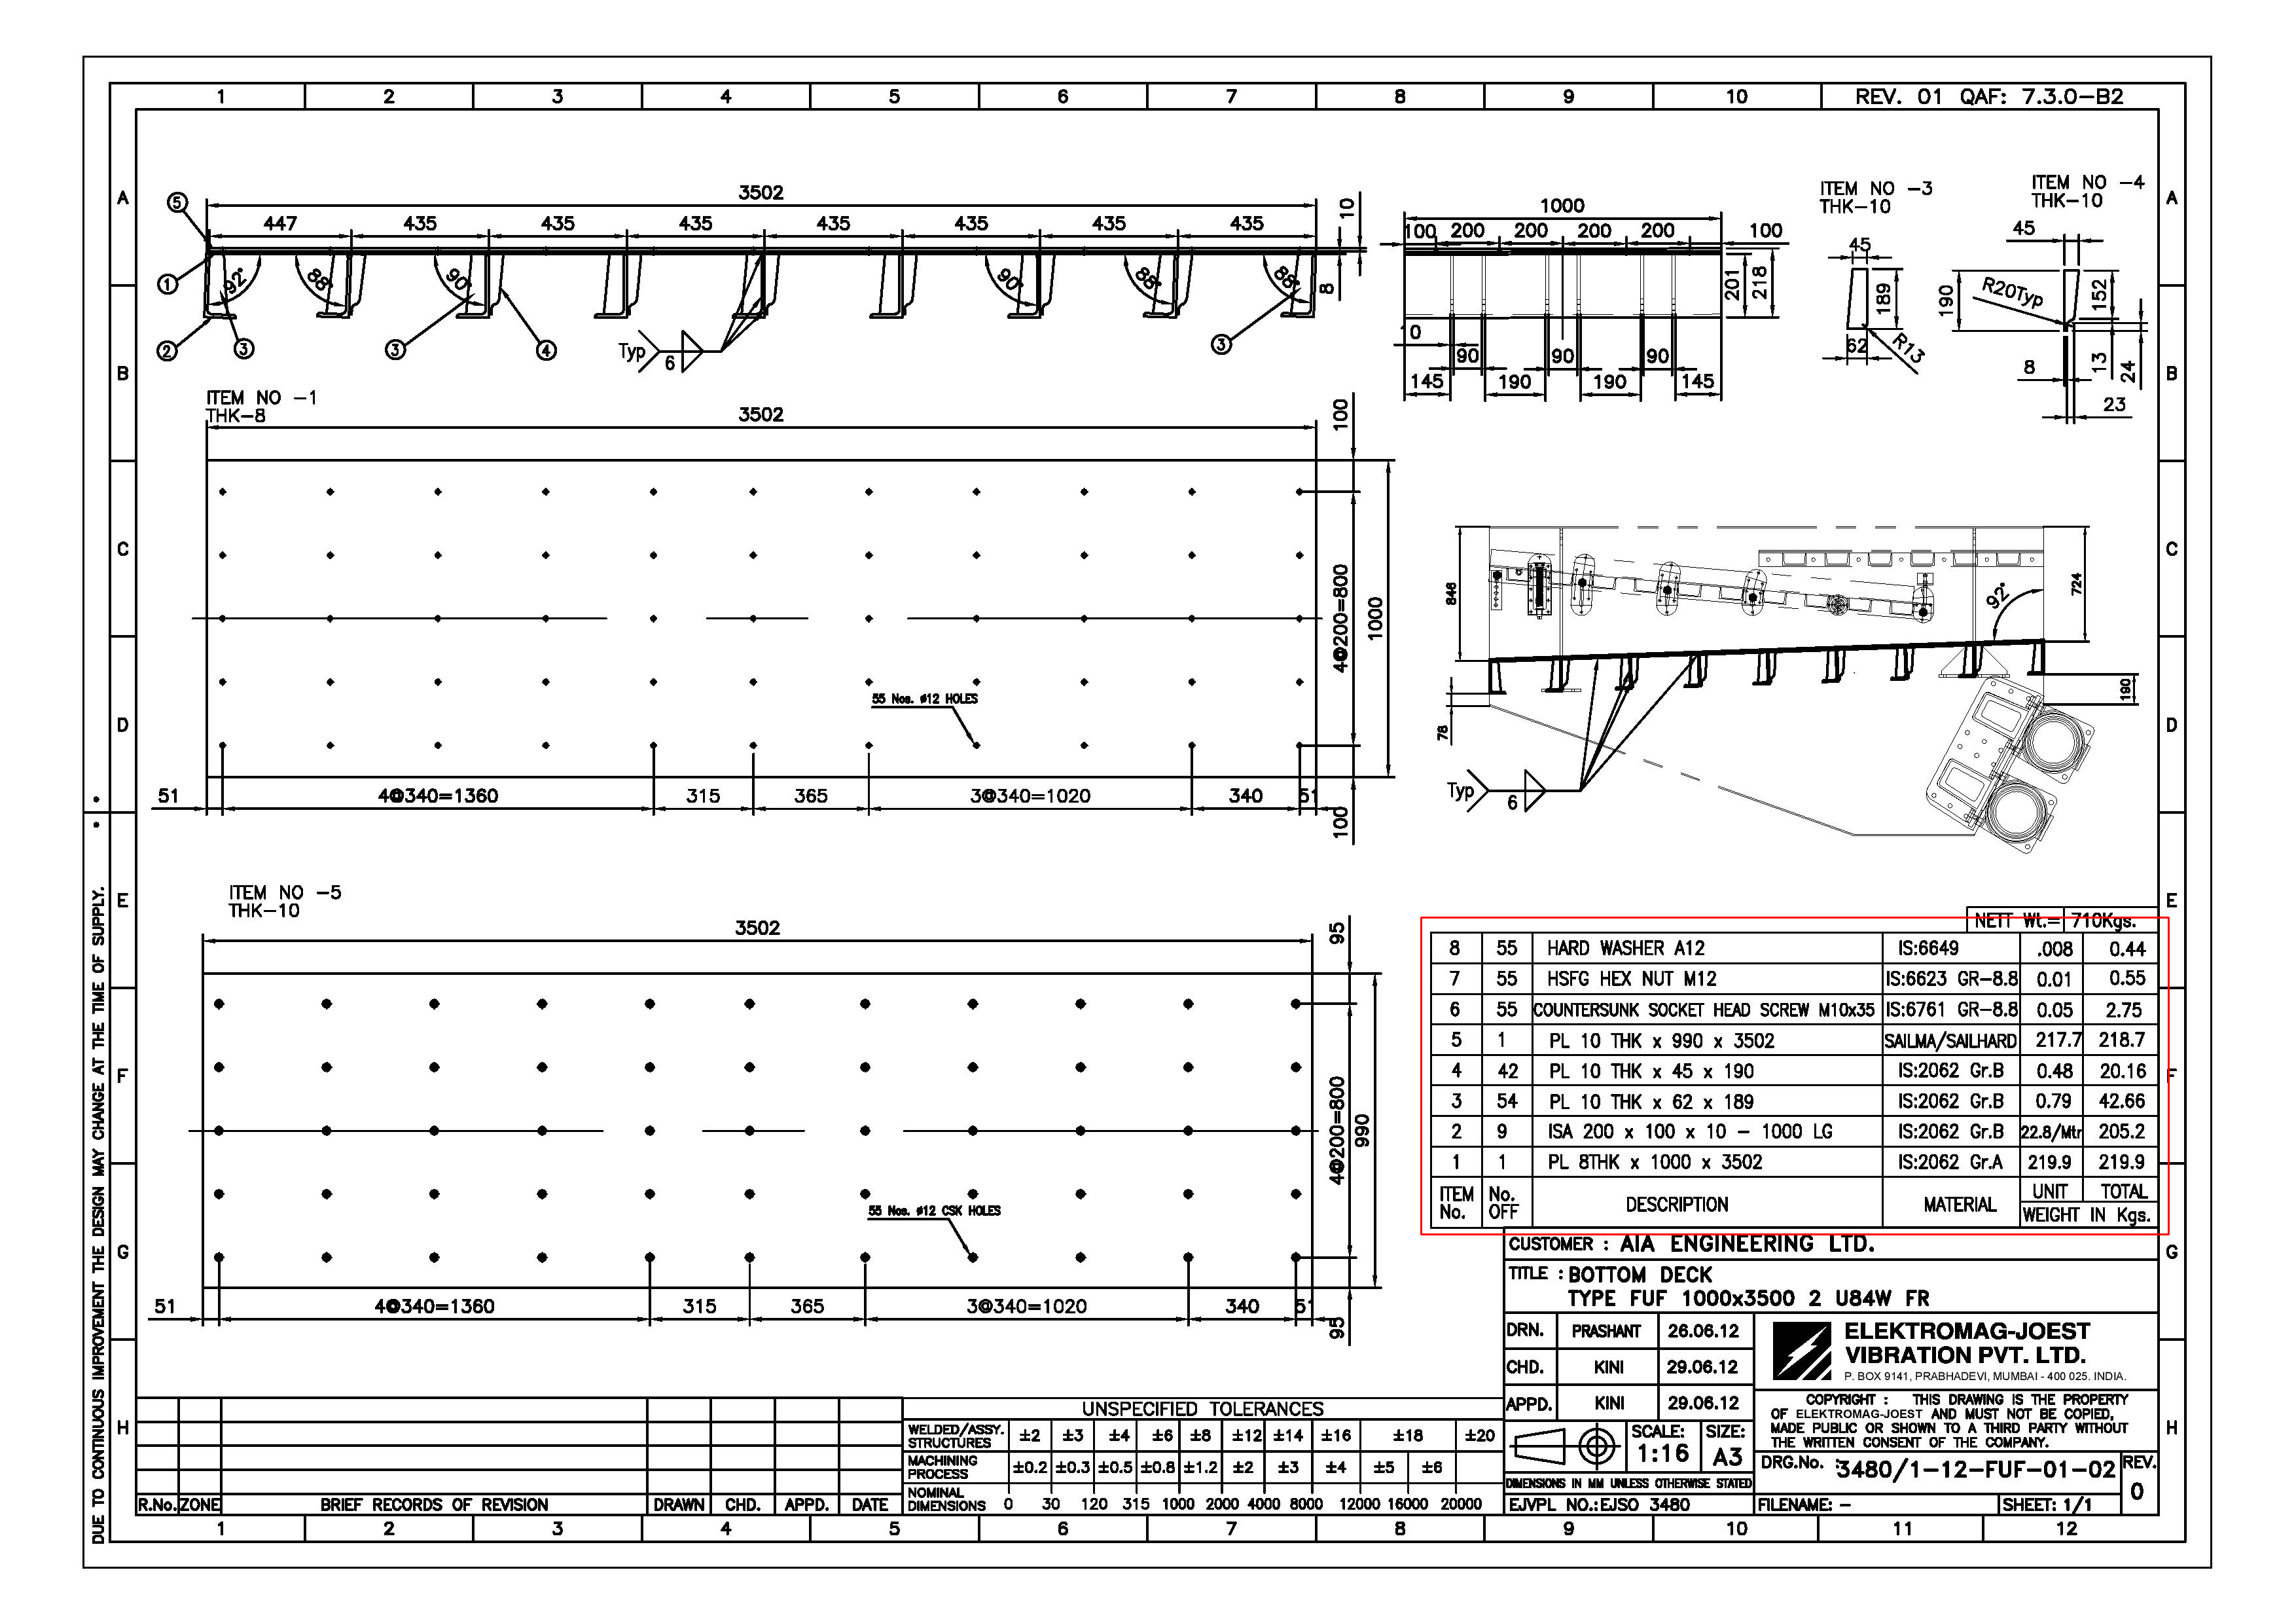

In [110]:
i = 1

x_path = r_data_master_unique['i_path'][i]
x = cv2.imread(x_path[0])

x_min = r_data_master_unique['x'][i]
x_max = r_data_master_unique['x'][i] + r_data_master_unique['width'][i]

y_min = r_data_master_unique['y'][i]
y_max = r_data_master_unique['y'][i] + r_data_master_unique['height'][i]

cv2.rectangle(x, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

x_pil = Image.fromarray(x)
display(x_pil)

checked upto i = 150, i=101 boundary box data to be changed.

In [105]:
print(r_data_master_unique['i_path'][i])

['/Users/subrata/workstation/jupyterFiles/yolo_data_file/drg_test_1/1002.jpg']


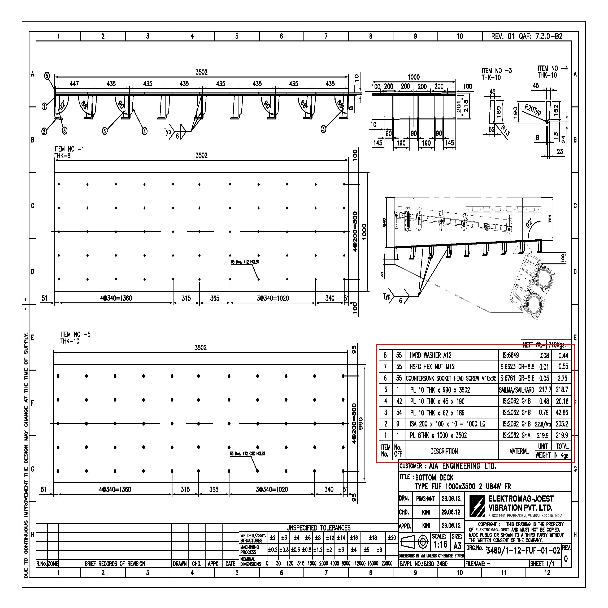

In [115]:
target_size = [608, 608]
target_w = 608 # target sizes of image in model input
target_h = 608 #target sizes of image in model input

i = 1

x_path = r_data_master_unique['i_path'][i]
x = cv2.imread(x_path[0])
x_resized = cv2.resize(x,(target_size[0], target_size[1]))

img_width = r_data_master_unique['img_wd'][i]
img_height = r_data_master_unique['img_ht'][i]

x_ratio = target_size[1] / img_width
y_ratio = target_size[0] / img_height

x_min_resized = round(r_data_master_unique['x'][i]*x_ratio)
x_max_resized = round(r_data_master_unique['x'][i]*x_ratio + r_data_master_unique['width'][i]*x_ratio)

y_min_resized = round(r_data_master_unique['y'][i] * y_ratio)
y_max_resized = round(r_data_master_unique['y'][i] * y_ratio + r_data_master_unique['height'][i] * y_ratio)

cv2.rectangle(x_resized, (x_min_resized, y_min_resized), (x_max_resized, y_max_resized), (255, 0, 0), 1)

x_pil = Image.fromarray(x_resized)
display(x_pil)

In [109]:
print(x_max)

2170


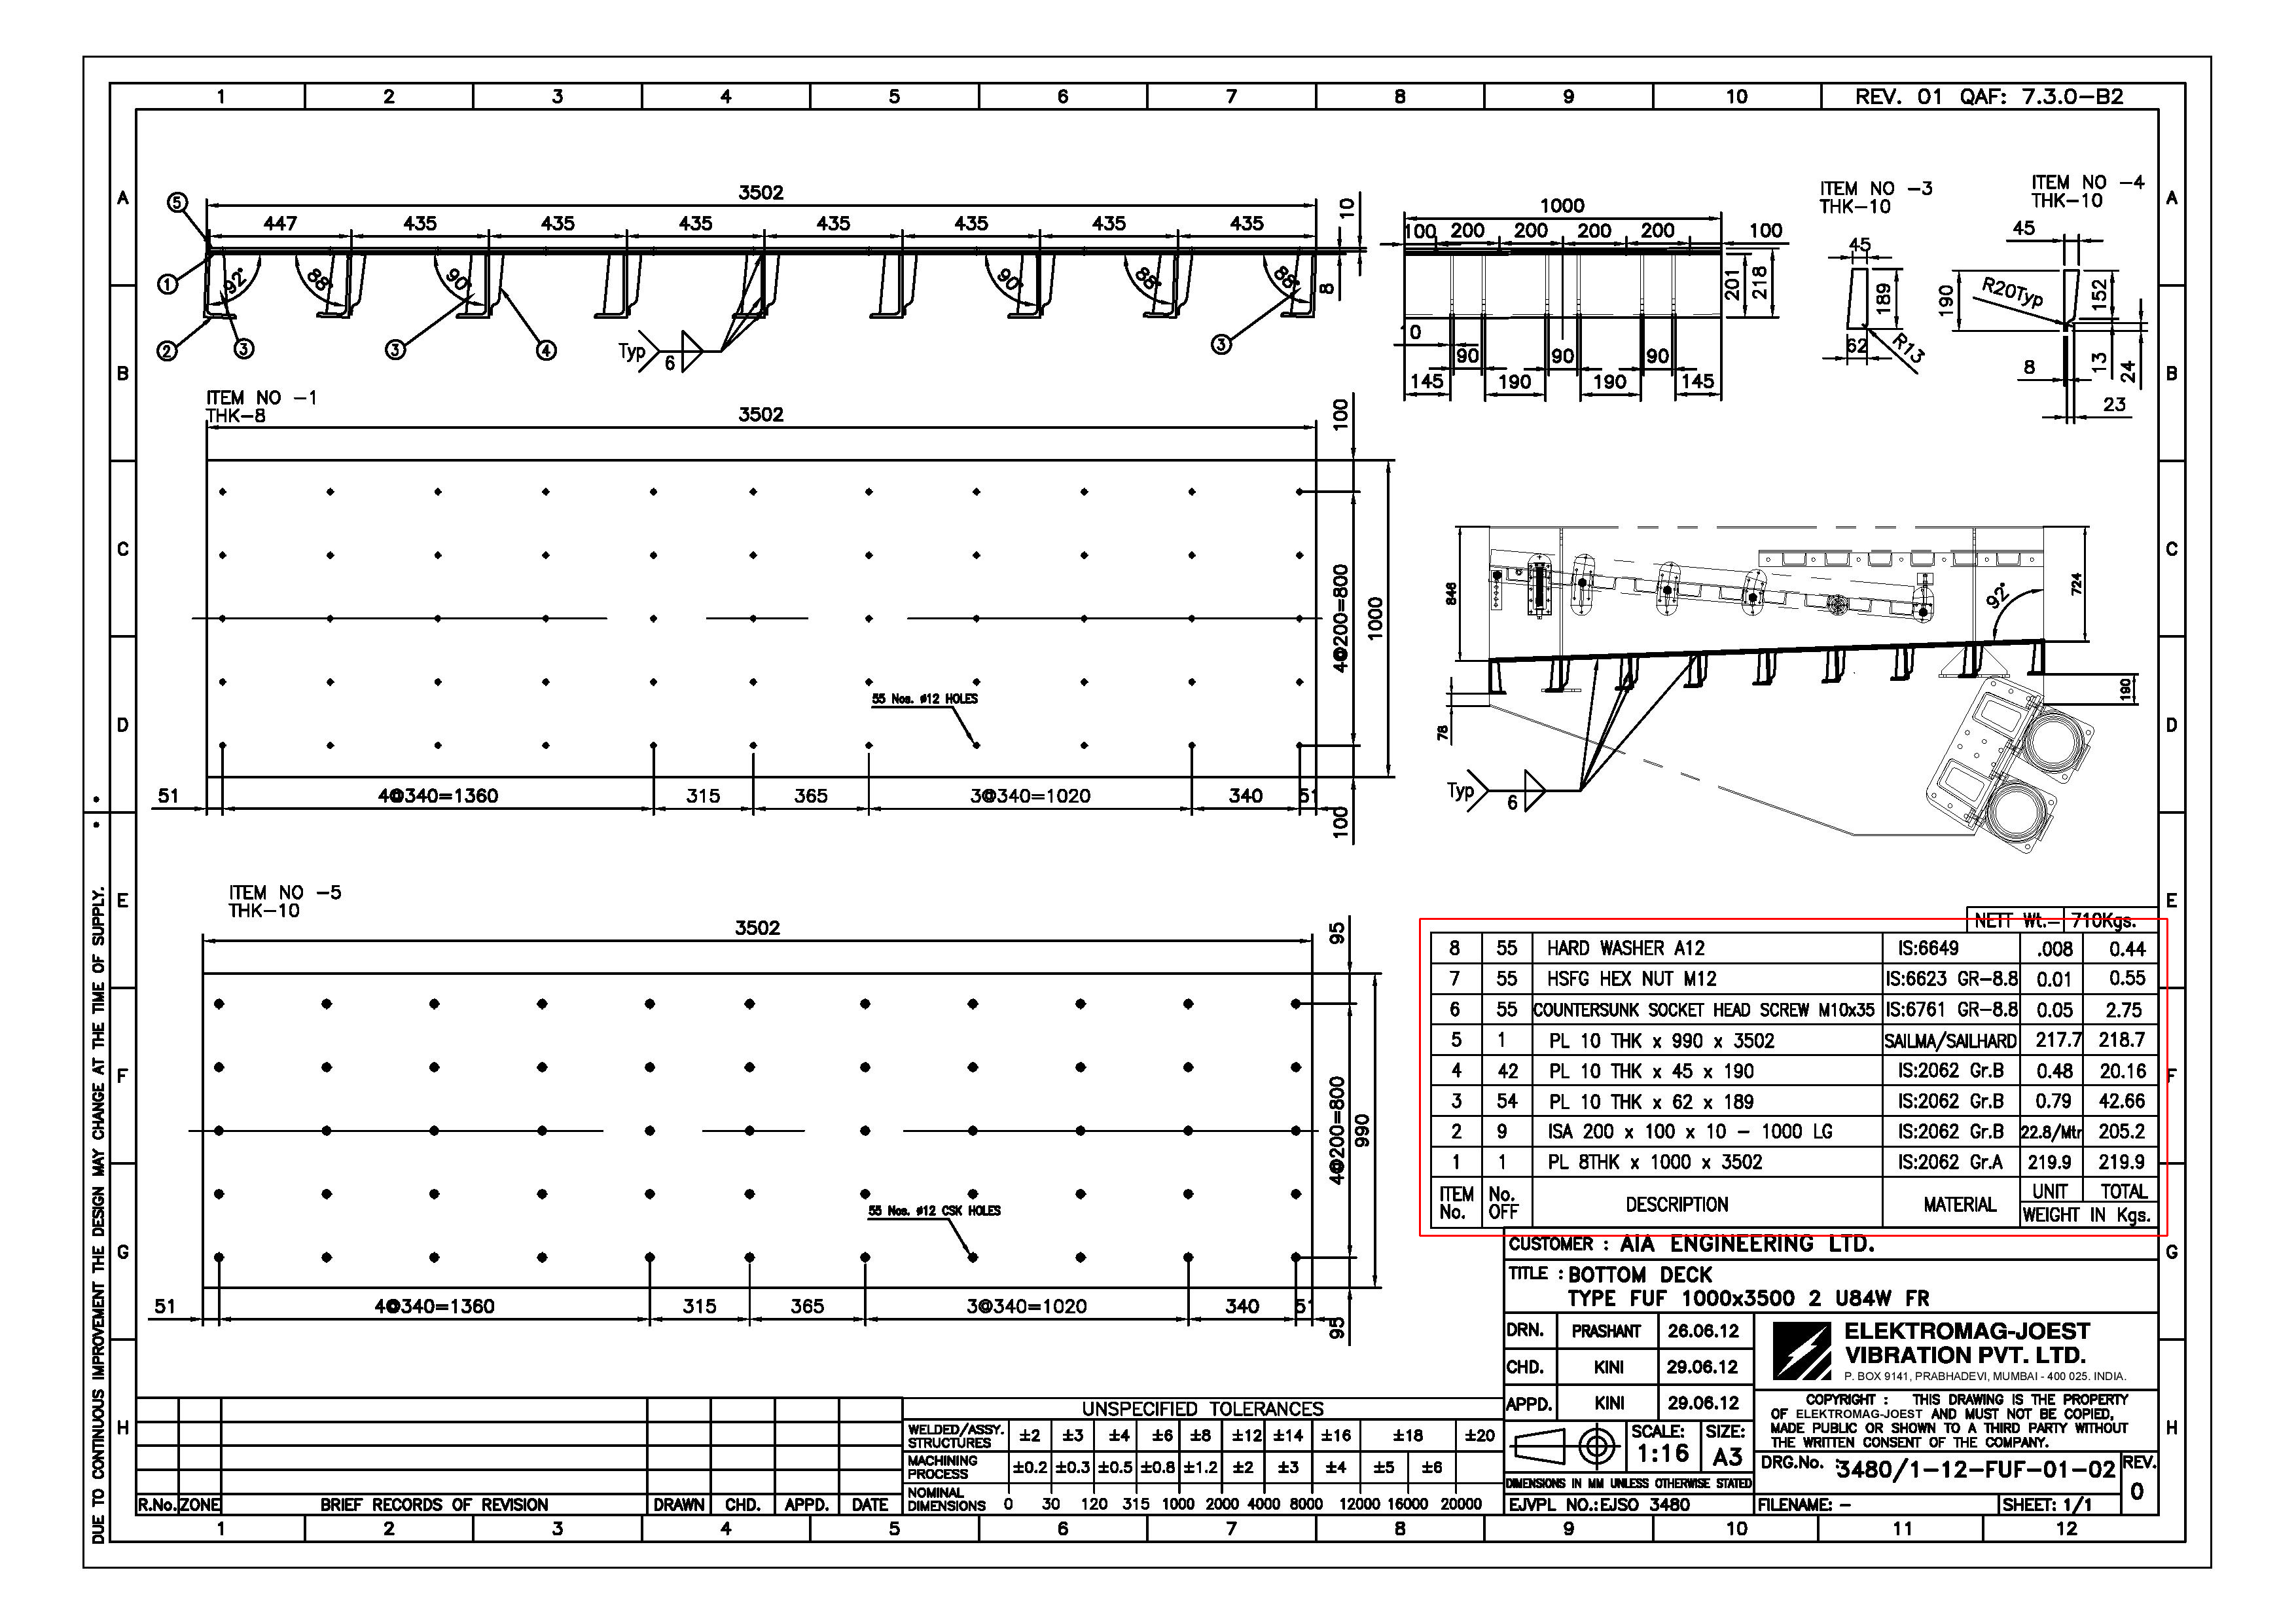

In [113]:

# x_min_resized = round(r_data_master_unique['x'][i]*x_ratio)
x_min = round(x_min_resized / x_ratio)
# x_max_resized = round(r_data_master_unique['x'][i]*x_ratio + r_data_master_unique['width'][i]*x_ratio)
x_max = x_min + r_data_master_unique['width'][i]

# y_min_resized = round(r_data_master_unique['y'][i] * y_ratio)
y_min = round(y_min_resized / y_ratio)
# y_max_resized = round(r_data_master_unique['y'][i] * y_ratio + r_data_master_unique['height'][i] * y_ratio)
y_max = y_min + r_data_master_unique['height'][i]

cv2.rectangle(x, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

x_pil = Image.fromarray(x)
display(x_pil)

In [49]:
def unsharp_mask(image, kernel_size=(7, 7), sigma=1.0, amount=1.0, threshold=0):
    

    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

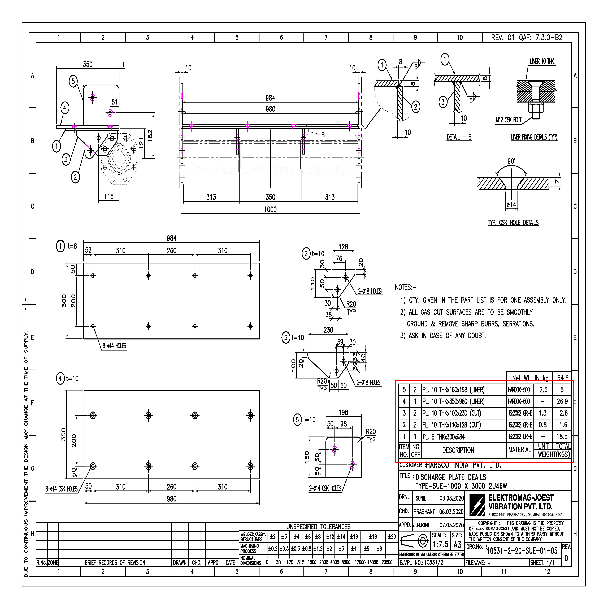

In [51]:
i = 1052

x_path = r_data_master_unique['i_path'][i]
x = cv2.imread(x_path[0])
x_resized = cv2.resize(x,(target_size[0], target_size[1]))

blurred_img = cv2.GaussianBlur(x_resized, (5, 5), 0)
sharpened_img = cv2.addWeighted(x_resized, 1.5, blurred_img, -0.5, 0)

# x_resized = unsharp_mask(x_resized)

img_width = r_data_master_unique['img_wd'][i]
img_height = r_data_master_unique['img_ht'][i]

x_ratio = target_size[1] / img_width
y_ratio = target_size[0] / img_height

x_min_resized = int(r_data_master_unique['x'][i]*x_ratio)
x_max_resized = int(r_data_master_unique['x'][i]*x_ratio + r_data_master_unique['width'][i]*x_ratio)

y_min_resized = int(r_data_master_unique['y'][i] * y_ratio)
y_max_resized = int(r_data_master_unique['y'][i] * y_ratio + r_data_master_unique['height'][i] * y_ratio)

cv2.rectangle(sharpened_img, (x_min_resized, y_min_resized), (x_max_resized, y_max_resized), (255, 0, 0), 1)

x_pil = Image.fromarray(sharpened_img)
display(x_pil)

In [134]:
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[608, 608, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(3, activation='sigmoid')(x)
model_1 = Model(vgg.input, x)
#model1.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
# plot the model
#plot_model(model1, "first_model.png",show_shapes=True,expand_nested=False)
print(model_1.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 608, 608, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 608, 608, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 608, 608, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 304, 304, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 304, 304, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 304, 304, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 152, 152, 128)     0   

In [ ]:
## Loss function
## box_reg_weights is a scalar value that controls the weight of the bounding box regression loss compared to the classification loss. 
## This parameter is used to balance the contribution of the two components to the total loss.
## A typical value for box_reg_weights in this case might be in the range of 1.0 to 10.0, depending on the specific problem and the amount
## of training data available.

import keras.backend as K
from keras.losses import binary_crossentropy

def smooth_l1_loss(y_true, y_pred):
    """
    Compute the smooth L1 loss between y_true and y_pred.
    """
    diff = K.abs(y_true - y_pred)
    less_than_one = K.cast(K.less(diff, 1.0), "float32")
    loss = (less_than_one * 0.5 * diff ** 2) + (1 - less_than_one) * (diff - 0.5)
    return K.sum(loss, axis=-1)

def faster_rcnn_loss(num_classes, bbox_reg_weights):
    """
    Compute the Faster R-CNN loss function.
    """
    def loss_fn(y_true, y_pred):
        # Split the predictions into classification and regression outputs
        class_preds = y_pred[:, :, :num_classes]
        bbox_preds = y_pred[:, :, num_classes:]

        # Split the targets into classification and regression targets
        class_labels = y_true[:, :, :num_classes]
        bbox_targets = y_true[:, :, num_classes:-1]
        bbox_masks = y_true[:, :, -1]

        # Compute the classification loss
        class_loss = binary_crossentropy(class_labels, class_preds)
        class_loss = K.mean(class_loss)

        # Compute the regression loss
        bbox_loss = smooth_l1_loss(bbox_targets, bbox_preds)
        bbox_loss = K.sum(bbox_loss * bbox_masks) / K.maximum(K.sum(bbox_masks), 1)

        # Compute the total loss
        total_loss = class_loss + bbox_reg_weights * bbox_loss
        return total_loss

    return loss_fn



In [156]:
def single_image_info(lines):
    
    ## lines will be a dataframe like, for i in range(num_images), lines = r_new_data[i*5:(i+1)*5]
    
    line_idx = lines.iat[0, 1]
    pic_path = lines.iat[0, 2]
    img_width = lines.iat[0, 8]
    img_height = lines.iat[0, 9]
    
    boxes = []
    labels = []
    for i in range(len(lines)):
        
        index_of = lines['obj_class'][i]
        label = categories.index(index_of)
        x_min, y_min, x_max, y_max = float(lines.iat[i,3]), float(lines.iat[i,4]), float(lines.iat[i,3]+lines.iat[i,5]), float(lines.iat[i,4]+lines.iat[i,6])
        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(label)
        
    boxes = np.asarray(boxes, np.float32)
    labels = np.asarray(labels, np.int64)
    
    return line_idx, pic_path, boxes, labels, img_width, img_height  ## boxes are in format xmin, ymin, xmax, ymax


In [157]:
## Creating the complete data set :

all_image_line = []
limit_lower = 0
limit_upper = 0

for i in range(num_images):

    image_line = []
    
    img = r_data_master_unique['img_id'][limit_upper]
    kount = r_data_master_unique['img_id'].value_counts()[img]      ## this gives no. of same images with region data of multiple categories
       
    limit_lower = limit_upper
    limit_upper = limit_lower + kount
    
    lines = r_data_master_unique[limit_lower:limit_upper].reset_index(drop=True)
    """
    print('===================', i)
    print(img)
    print(limit_lower)
    print(limit_upper)
    """
    
    line_idx, pic_path, boxes, labels, img_width, img_height = single_image_info(lines)
    image_line.append(line_idx)                                                                  ## line_idx = index of the same image in df_new dataframe
    image_line.append(pic_path)                                                                  ## pic_path = path of the image
    image_line.append(boxes)                                                                     ## boxes are in format xmin, ymin, xmax, ymax
    image_line.append(labels)                                                                    ## labels are in form of index no. in 'categories' list 
    image_line.append(img_width)
    image_line.append(img_height)
    all_image_line.append(image_line)
    
print(len(all_image_line))
print(all_image_line[100])   ##  boxes are in format xmin, ymin, xmax, ymax

1054
[100, ['/Users/subrata/workstation/jupyterFiles/yolo_data_file/drg_test_3/1103.jpg'], array([[2202., 1597., 3193., 1826.]], dtype=float32), array([0]), 3509, 2480]


In [71]:
print(r_data_master_unique.loc[[100]])

       img_id  img_idx                                             i_path  \
100  1103.jpg      100  [/Users/subrata/workstation/jupyterFiles/yolo_...   

        x     y  width  height obj_class  img_wd  img_ht  
100  2202  1597    991     229       bom    3509    2480  


In [158]:
# Train and Test split

data_train, data_val = train_test_split(all_image_line, train_size = 0.80 , shuffle = True)

num_all_bbox = len(all_image_line) * len(all_image_line[0][2])
num_bb_train = len(data_train) * len(data_train[0][2])
num_bb_val = len(data_val) * len(data_val[0][2])
print(num_all_bbox, num_bb_train, num_bb_val)

1054 843 211


In [124]:
print(type(data_train))
print(data_train[0][0])
print(len(data_train[0]))

<class 'list'>
339
6


In [159]:
image_index = []
image_resized = []
image_y_true = []

y_true = np.zeros((1,4), np.float32)

for i in range(len(data_train)):

    y_true[0][0] = data_train[i][2][0][0] / data_train[i][4]
    y_true[0][1] = data_train[i][2][0][1] / data_train[i][5]
    y_true[0][2] = data_train[i][2][0][2] / data_train[i][4]
    y_true[0][3] = data_train[i][2][0][3] / data_train[i][5]

    image_y_true.append(y_true)

    img_idx = data_train[i][0]
    img = cv2.imread(data_train[i][1][0])
    img_resized = cv2.resize(img,(target_size[0], target_size[1]))
    img_resized = (img_resized - 127.5)/ 255.

    image_index.append(img_idx)
    image_resized.append(img_resized)

X_train = np.array(image_resized).astype(np.float32)
Y_train = np.array(image_y_true).astype(np.float32)   
train_image_idx = image_index


In [128]:
print(X_train.shape)
print(type(X_train))
print(Y_train.shape)
print(type(Y_train))
print(len(train_image_idx))
print(type(train_image_idx))

# print(X_train[0])
# print(Y_train[0])

(843, 608, 608, 3)
<class 'numpy.ndarray'>
(843, 1, 4)
<class 'numpy.ndarray'>
843
<class 'list'>


In [160]:
image_index = []
image_resized = []
image_y_true = []

y_true = np.zeros((1,4), np.float32)

for i in range(len(data_val)):

    y_true[0][0] = data_val[i][2][0][0] / data_val[i][4]
    y_true[0][1] = data_val[i][2][0][1] / data_val[i][5]
    y_true[0][2] = data_val[i][2][0][2] / data_val[i][4]
    y_true[0][3] = data_val[i][2][0][3] / data_val[i][5]

    image_y_true.append(y_true)

    img_idx = data_val[i][0]
    img = cv2.imread(data_val[i][1][0])
    img_resized = cv2.resize(img,(target_size[0], target_size[1]))
    img_resized = (img_resized - 127.5)/ 255.

    image_index.append(img_idx)
    image_resized.append(img_resized)

X_val = np.array(image_resized).astype(np.float32)
Y_val = np.array(image_y_true).astype(np.float32)   
val_image_idx = image_index


In [131]:
print(X_val.shape)
print(type(X_val))
print(Y_val.shape)
print(type(Y_val))
print(len(val_image_idx))
print(type(val_image_idx))


(211, 608, 608, 3)
<class 'numpy.ndarray'>
(211, 1, 4)
<class 'numpy.ndarray'>
211
<class 'list'>


In [161]:
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[608, 608, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)

x = Dense(4, activation = 'linear')(x)
model_new_1 = Model(vgg.input, x)
#model1.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
# plot the model
#plot_model(model1, "first_model.png",show_shapes=True,expand_nested=False)
print(model_new_1.summary())

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 608, 608, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 608, 608, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 608, 608, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 304, 304, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 304, 304, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 304, 304, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 152, 152, 128)     0   

In [162]:
epoch = 25
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model_new_1.compile(optimizer= opt, loss = 'mse')
# my_model_1.fit(X_data_train,Y_data_train, epochs=epoch, batch_size = 8, validation_data=(X_data_val,Y_data_val))

In [163]:
history = model_new_1.fit(X_train,Y_train, epochs=epoch, batch_size = 8, validation_data=(X_val,Y_val))

Epoch 1/25
106/106 [==============================] - 3285s 31s/step - loss: 0.1318 - val_loss: 0.0050
Epoch 2/25
106/106 [==============================] - 3562s 34s/step - loss: 1.2653e-04 - val_loss: 0.0044
Epoch 3/25
106/106 [==============================] - 4017s 38s/step - loss: 6.7490e-05 - val_loss: 0.0048
Epoch 4/25
106/106 [==============================] - 3344s 32s/step - loss: 4.5917e-05 - val_loss: 0.0054
Epoch 5/25
106/106 [==============================] - 3315s 31s/step - loss: 3.4229e-05 - val_loss: 0.0050
Epoch 6/25
106/106 [==============================] - 3059s 29s/step - loss: 2.9995e-05 - val_loss: 0.0049
Epoch 7/25
106/106 [==============================] - 3558s 34s/step - loss: 2.3147e-05 - val_loss: 0.0051
Epoch 8/25
106/106 [==============================] - 3073s 29s/step - loss: 1.8415e-05 - val_loss: 0.0052
Epoch 9/25
106/106 [==============================] - 3089s 29s/step - loss: 1.4754e-05 - val_loss: 0.0053
Epoch 10/25
106/106 [====================

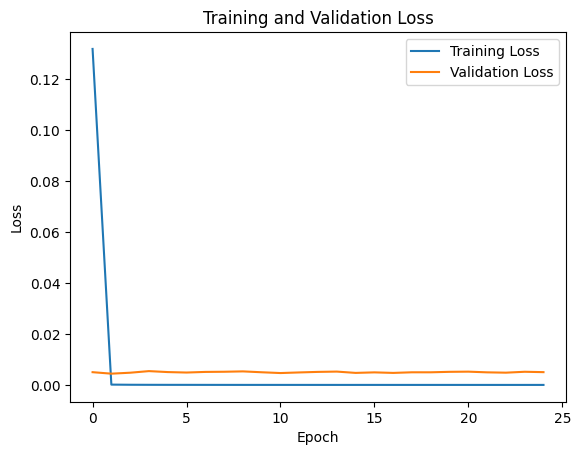

In [164]:
# Train the model
# history = model_new_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [293]:
test_region_data = []

test_region = pd.read_csv('/Users/subrata/workstation/jupyterFiles/testdrg/via_project_test_csv.csv')
test_region_data.append(test_region)

test_data = pd.concat(test_region_data)

In [221]:
test_data.head(10)

filename  file_size file_attributes  region_count  region_id  \
0  SM-MFD-5KW-006-23.jpg     922506              {}             1          0   
1  SM-MFD-5KW-005-23.jpg     850997              {}             1          0   
2  SM-MFD-5KW-004-23.jpg     603877              {}             1          0   
3  SM-MFD-5KW-003-23.jpg     586413              {}             1          0   
4  SM-MFD-5KW-002-23.jpg     717321              {}             1          0   
5  SM-MFD-5KW-001-23.jpg    1191920              {}             1          0   

                             region_shape_attributes region_attributes  
0  {"name":"rect","x":2014,"y":1412,"width":1460,...        {"bom":""}  
1  {"name":"rect","x":2007,"y":1629,"width":1463,...        {"bom":""}  
2  {"name":"rect","x":1923,"y":1789,"width":1425,...        {"bom":""}  
3  {"name":"rect","x":1908,"y":1812,"width":1443,...        {"bom":""}  
4  {"name":"rect","x":1911,"y":1771,"width":1437,...        {"bom":""}  
5  {"name":"rect","x":2158,"y":1373,"width":1201,...        {"bom":""}

In [294]:
# Create test_data_master having bbox information :

test_data_master = test_data[~test_data['region_shape_attributes'].str.contains('{}')].reset_index(drop=True)
test_data_master_unique = test_data_master.drop_duplicates('filename', keep=False).reset_index(drop=True)
test_data_master_unique.drop(test_data_master_unique.columns[[1, 2, 3, 4]], axis=1, inplace=True) # reduce unnecessary columns
num_images_in_data_master = test_data_master_unique["filename"].nunique()
test_data_master_image_list = test_data_master_unique["filename"].tolist()

print(num_images_in_data_master)

test_data_master_unique.head(10)


6


filename                            region_shape_attributes  \
0  SM-MFD-5KW-006-23.jpg  {"name":"rect","x":2014,"y":1412,"width":1460,...   
1  SM-MFD-5KW-005-23.jpg  {"name":"rect","x":2007,"y":1629,"width":1463,...   
2  SM-MFD-5KW-004-23.jpg  {"name":"rect","x":1923,"y":1789,"width":1425,...   
3  SM-MFD-5KW-003-23.jpg  {"name":"rect","x":1908,"y":1812,"width":1443,...   
4  SM-MFD-5KW-002-23.jpg  {"name":"rect","x":1911,"y":1771,"width":1437,...   
5  SM-MFD-5KW-001-23.jpg  {"name":"rect","x":2158,"y":1373,"width":1201,...   

  region_attributes  
0        {"bom":""}  
1        {"bom":""}  
2        {"bom":""}  
3        {"bom":""}  
4        {"bom":""}  
5        {"bom":""}

In [295]:
all_test_drg_path = []

test_img_path = '/Users/subrata/workstation/jupyterFiles/testdrg/'
for i in range(len(test_data_master_unique)):
    new_file_name = test_img_path + test_data_master_unique['filename'][i]
    new_file_name_to_list = [new_file_name]
    all_test_drg_path.append(new_file_name_to_list)
    

test_img_path_values = pd.Series(all_test_drg_path)
test_data_master_unique.insert(loc=1, column='i_path', value=test_img_path_values)

test_data_master_unique.head(10)

filename                                             i_path  \
0  SM-MFD-5KW-006-23.jpg  [/Users/subrata/workstation/jupyterFiles/testd...   
1  SM-MFD-5KW-005-23.jpg  [/Users/subrata/workstation/jupyterFiles/testd...   
2  SM-MFD-5KW-004-23.jpg  [/Users/subrata/workstation/jupyterFiles/testd...   
3  SM-MFD-5KW-003-23.jpg  [/Users/subrata/workstation/jupyterFiles/testd...   
4  SM-MFD-5KW-002-23.jpg  [/Users/subrata/workstation/jupyterFiles/testd...   
5  SM-MFD-5KW-001-23.jpg  [/Users/subrata/workstation/jupyterFiles/testd...   

                             region_shape_attributes region_attributes  
0  {"name":"rect","x":2014,"y":1412,"width":1460,...        {"bom":""}  
1  {"name":"rect","x":2007,"y":1629,"width":1463,...        {"bom":""}  
2  {"name":"rect","x":1923,"y":1789,"width":1425,...        {"bom":""}  
3  {"name":"rect","x":1908,"y":1812,"width":1443,...        {"bom":""}  
4  {"name":"rect","x":1911,"y":1771,"width":1437,...        {"bom":""}  
5  {"name":"rect","x":2158,"y":1373,"width":1201,...        {"bom":""}

In [348]:
test_data_master_unique['i_path'][0]

['/Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-006-23.jpg']

In [296]:
# Check sizes of exiting images & Create a Dataframe with image id and height(row) and width(column):

rows = []
columns = []
#image_sl = []
# df_image_size = pd.DataFrame()

for i in range(len(test_data_master_unique)):
 #   print(i)
    image = cv2.imread(test_data_master_unique['i_path'][i][0]) ## Loading image
    
    height, width, _ = image.shape
    rows.append(height)
    columns.append(width)
    image_sl.append(reqd_drg_image[i][0])
print(len(rows))      
row_values = pd.Series(rows)
col_values = pd.Series(columns)
#image_num = pd.Series(image_sl)


#test_data_master_unique.insert(loc=1, column='image_serial', value=image_num)
test_data_master_unique.insert(loc=2, column='image_ht', value=row_values)
test_data_master_unique.insert(loc=2, column='image_wd', value=col_values)

test_data_master_unique.head(10)

6


filename                                             i_path  \
0  SM-MFD-5KW-006-23.jpg  [/Users/subrata/workstation/jupyterFiles/testd...   
1  SM-MFD-5KW-005-23.jpg  [/Users/subrata/workstation/jupyterFiles/testd...   
2  SM-MFD-5KW-004-23.jpg  [/Users/subrata/workstation/jupyterFiles/testd...   
3  SM-MFD-5KW-003-23.jpg  [/Users/subrata/workstation/jupyterFiles/testd...   
4  SM-MFD-5KW-002-23.jpg  [/Users/subrata/workstation/jupyterFiles/testd...   
5  SM-MFD-5KW-001-23.jpg  [/Users/subrata/workstation/jupyterFiles/testd...   

   image_wd  image_ht                            region_shape_attributes  \
0      3508      2479  {"name":"rect","x":2014,"y":1412,"width":1460,...   
1      3508      2479  {"name":"rect","x":2007,"y":1629,"width":1463,...   
2      3508      2479  {"name":"rect","x":1923,"y":1789,"width":1425,...   
3      3508      2479  {"name":"rect","x":1908,"y":1812,"width":1443,...   
4      3508      2479  {"name":"rect","x":1911,"y":1771,"width":1437,...   
5      3508      2479  {"name":"rect","x":2158,"y":1373,"width":1201,...   

  region_attributes  
0        {"bom":""}  
1        {"bom":""}  
2        {"bom":""}  
3        {"bom":""}  
4        {"bom":""}  
5        {"bom":""}

In [297]:
# Making a dataframe for Image_id, x, y, width, height, class, image_width and image_height

x = []  # co-ordinate of bbox left-top corner and NOT center of bbox
y = []  # co-ordinate of bbox left-top corner and NOT center of bbox
width = []
height = []
obj_class = []
#i_width = []
#i_height = []
#img_path = []
img_index = []

for i in range(len(test_data_master_unique)):
    
    test_size = test_data_master_unique.values[i, 4][1:(len(test_data_master_unique.values[i, 4])-1)]
    test_size_par = test_size.split(",")
    
    # print(i)
    
    x.append(int("".join(filter(str.isdigit, test_size_par[1]))))
#    print('=================================================')
    y.append(int("".join(filter(str.isdigit, test_size_par[2]))))
    width.append(int("".join(filter(str.isdigit, test_size_par[3]))))
    height.append(int("".join(filter(str.isdigit, test_size_par[4]))))
    img_index.append(i)
    
    test_attribs = test_data_master_unique.values[i, 5][1:(len(test_data_master_unique.values[i, 5])-1)]
    test_attribs_par = test_attribs.split(':')[1]
    obj_class.append(r_attribs_par[1:(len(r_attribs_par)-1)])
    
x_values = pd.Series(x)
y_values = pd.Series(y)
width_values = pd.Series(width)
height_values = pd.Series(height)
class_values = pd.Series(obj_class)
img_index_values = pd.Series(img_index)

test_data_master_unique.insert(loc=1, column='Img_Idx', value=img_index_values)
test_data_master_unique.insert(loc=3, column='x', value=x_values)
test_data_master_unique.insert(loc=4, column='y', value=y_values)
test_data_master_unique.insert(loc=5, column='width', value=width_values)
test_data_master_unique.insert(loc=6, column='height', value=height_values)
test_data_master_unique.insert(loc=7, column='obj_class', value=class_values)

test_data_master_unique.drop(test_data_master_unique.columns[[10,11]], axis=1, inplace=True) # reduce unnecessary columns

test_data_master_unique.rename({'filename': 'img_id'}, axis=1, inplace=True) # changing column name

num_images = len(test_data_master_unique)
print(num_images)

test_data_master_unique.tail(3)


6


img_id  Img_Idx  \
3  SM-MFD-5KW-003-23.jpg        3   
4  SM-MFD-5KW-002-23.jpg        4   
5  SM-MFD-5KW-001-23.jpg        5   

                                              i_path     x     y  width  \
3  [/Users/subrata/workstation/jupyterFiles/testd...  1908  1812   1443   
4  [/Users/subrata/workstation/jupyterFiles/testd...  1911  1771   1437   
5  [/Users/subrata/workstation/jupyterFiles/testd...  2158  1373   1201   

   height obj_class  image_wd  image_ht  
3     160       bom      3508      2479  
4     201       bom      3508      2479  
5     736       bom      3508      2479

In [298]:
test_data_master_unique.head(10)

img_id  Img_Idx  \
0  SM-MFD-5KW-006-23.jpg        0   
1  SM-MFD-5KW-005-23.jpg        1   
2  SM-MFD-5KW-004-23.jpg        2   
3  SM-MFD-5KW-003-23.jpg        3   
4  SM-MFD-5KW-002-23.jpg        4   
5  SM-MFD-5KW-001-23.jpg        5   

                                              i_path     x     y  width  \
0  [/Users/subrata/workstation/jupyterFiles/testd...  2014  1412   1460   
1  [/Users/subrata/workstation/jupyterFiles/testd...  2007  1629   1463   
2  [/Users/subrata/workstation/jupyterFiles/testd...  1923  1789   1425   
3  [/Users/subrata/workstation/jupyterFiles/testd...  1908  1812   1443   
4  [/Users/subrata/workstation/jupyterFiles/testd...  1911  1771   1437   
5  [/Users/subrata/workstation/jupyterFiles/testd...  2158  1373   1201   

   height obj_class  image_wd  image_ht  
0     619       bom      3508      2479  
1     404       bom      3508      2479  
2     186       bom      3508      2479  
3     160       bom      3508      2479  
4     201       bom      3508      2479  
5     736       bom      3508      2479

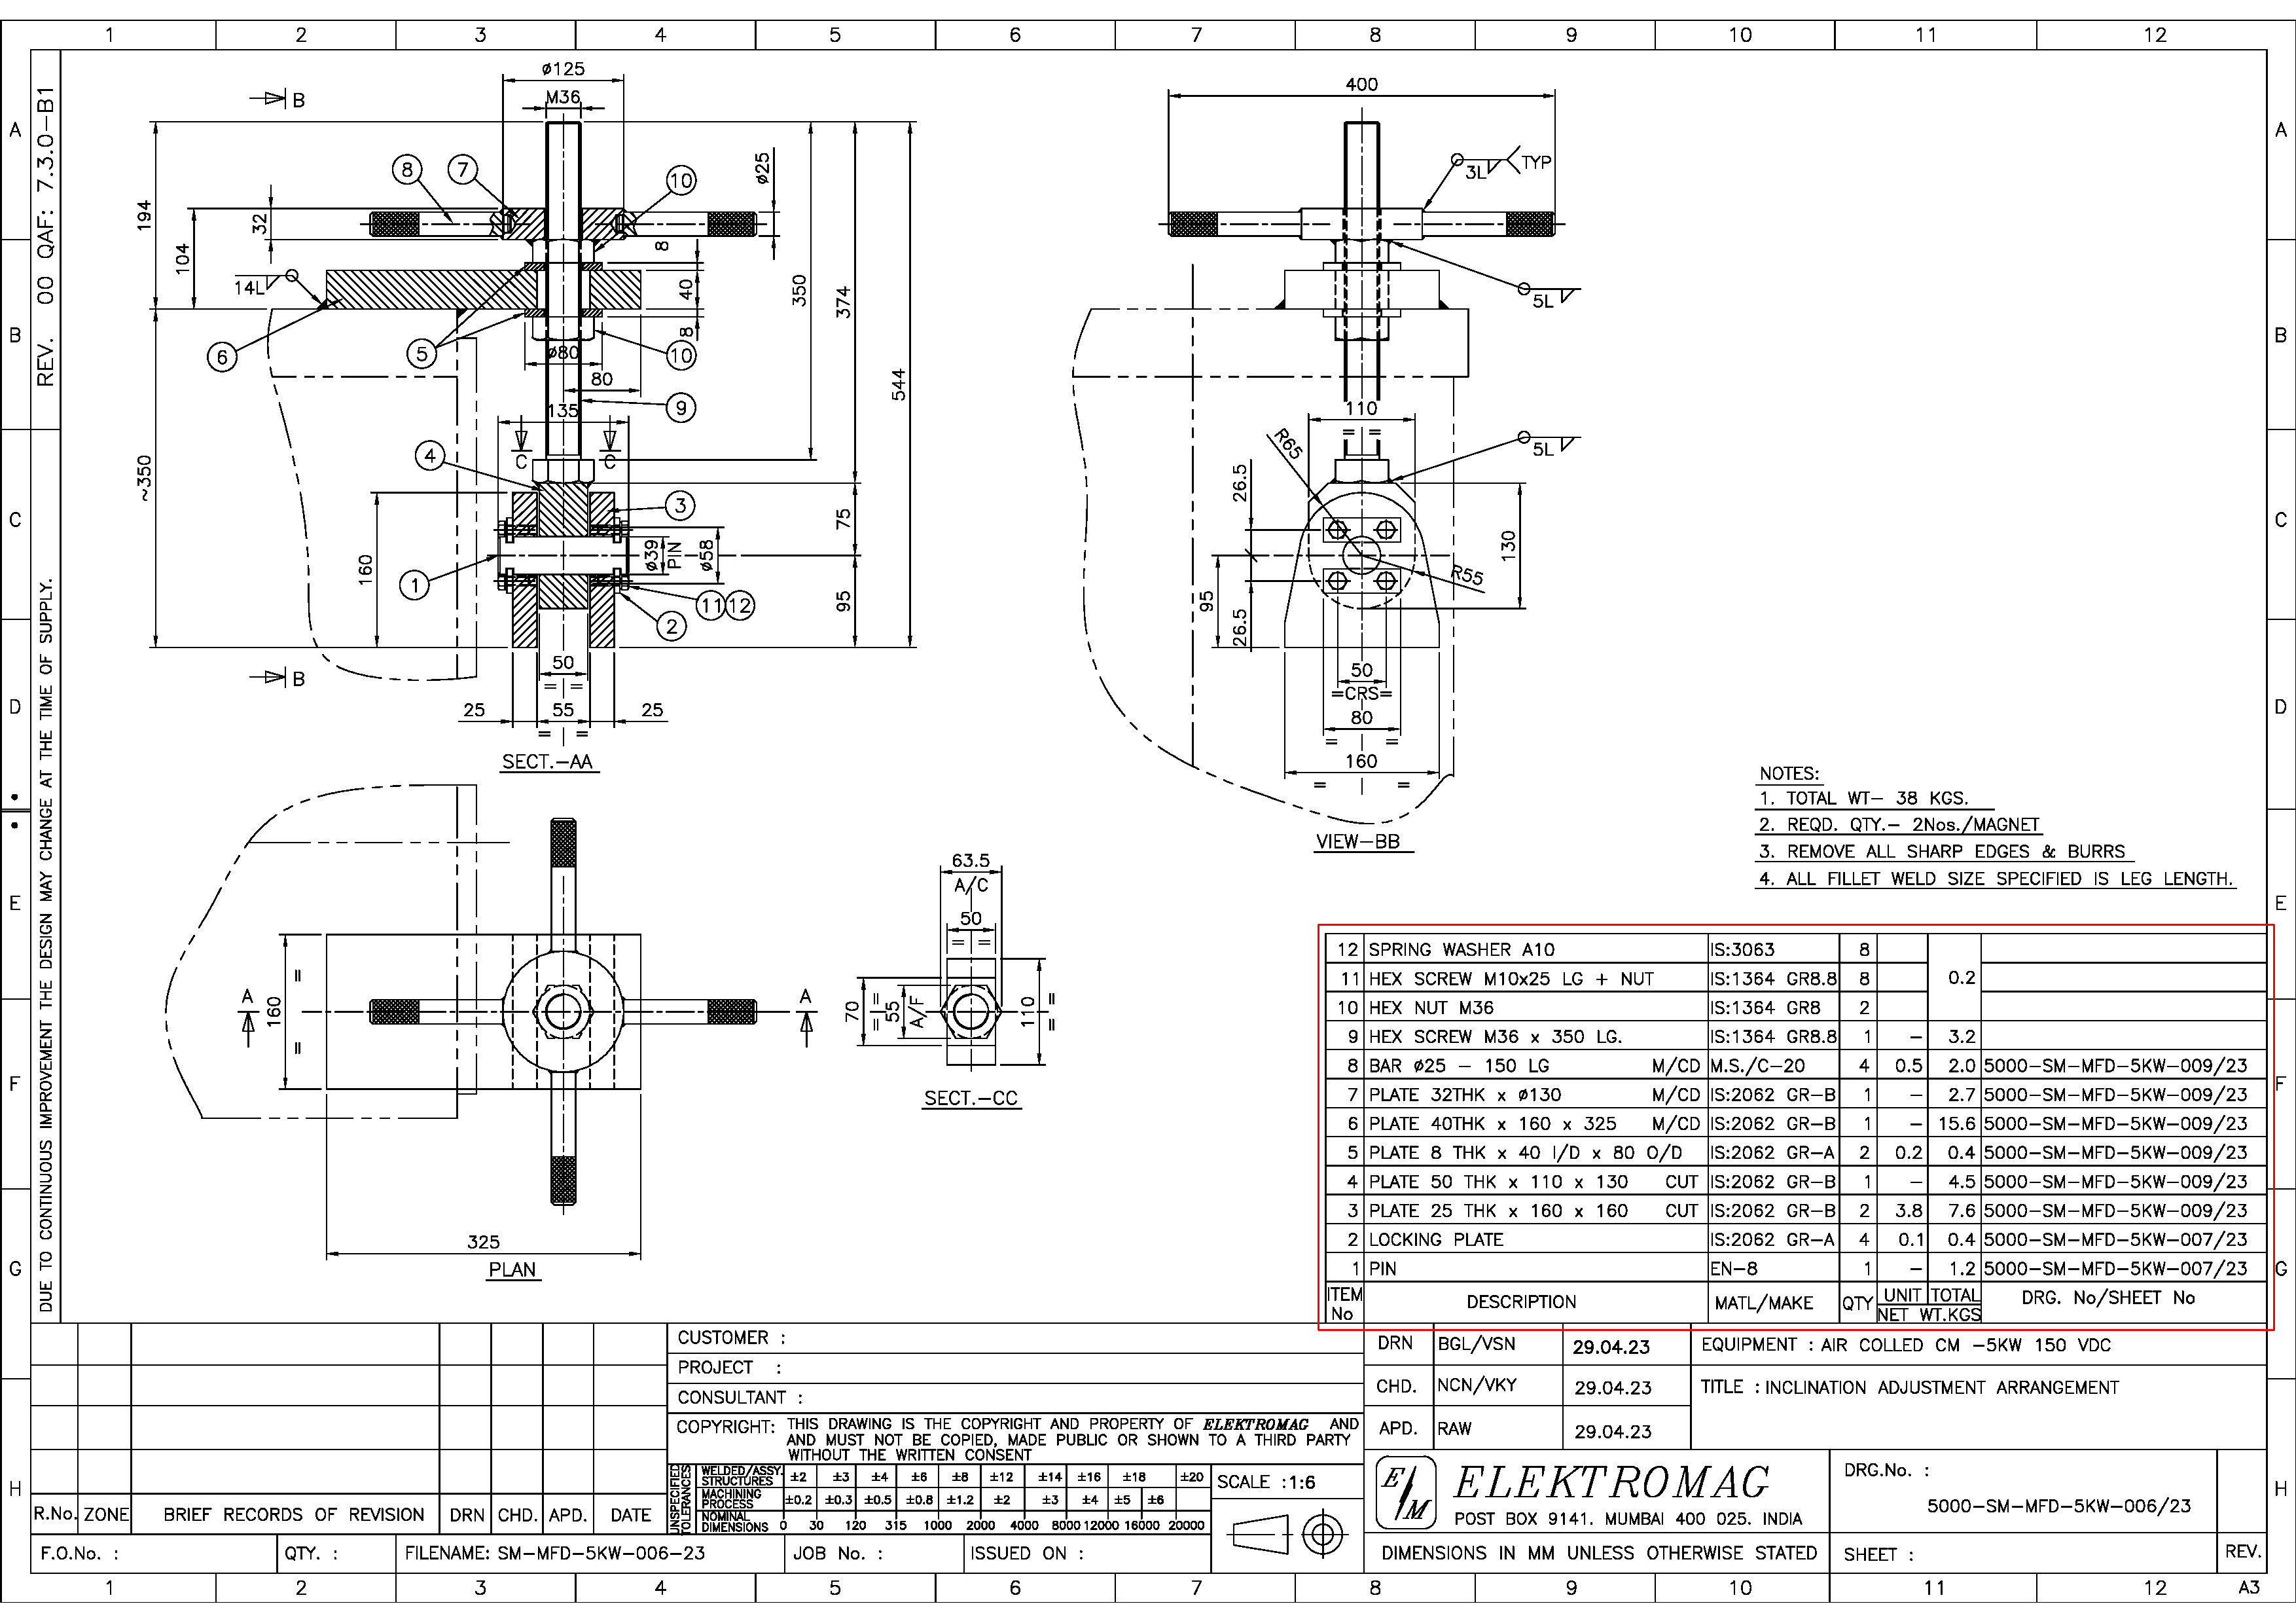

In [299]:
i = 0

x_path = test_data_master_unique['i_path'][i]
x = cv2.imread(x_path[0])

x_min = test_data_master_unique['x'][i]
x_max = test_data_master_unique['x'][i] + test_data_master_unique['width'][i]

y_min = test_data_master_unique['y'][i]
y_max = test_data_master_unique['y'][i] + test_data_master_unique['height'][i]

cv2.rectangle(x, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

x_pil = Image.fromarray(x)
display(x_pil)

In [300]:
def single_image_info(lines):
    
    line_idx = lines.iat[0, 1]
    pic_path = lines.iat[0, 2]
    img_width = lines.iat[0, 8]
    img_height = lines.iat[0, 9]
    
    boxes = []
    labels = []
    for i in range(len(lines)):
        
        index_of = lines['obj_class'][i]
        label = categories.index(index_of)
        x_min, y_min, x_max, y_max = float(lines.iat[i,3]), float(lines.iat[i,4]), float(lines.iat[i,3]+lines.iat[i,5]), float(lines.iat[i,4]+lines.iat[i,6])
        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(label)
        
    boxes = np.asarray(boxes, np.float32)
    labels = np.asarray(labels, np.int64)
    
    return line_idx, pic_path, boxes, labels, img_width, img_height  ## boxes are in format xmin, ymin, xmax, ymax


In [301]:
# Creating the complete data set :

## Creating the complete data set :

test_image_line = []
limit_lower = 0
limit_upper = 0

for i in range(num_images):

    image_line = []
    
    img = test_data_master_unique['img_id'][limit_upper]
    kount = test_data_master_unique['img_id'].value_counts()[img]      ## this gives no. of same images with region data of multiple categories
       
    limit_lower = limit_upper
    limit_upper = limit_lower + kount
    
    lines = test_data_master_unique[limit_lower:limit_upper].reset_index(drop=True)
    """
    print('===================', i)
    print(img)
    print(limit_lower)
    print(limit_upper)
    """
    
    line_idx, pic_path, boxes, labels, img_width, img_height = single_image_info(lines)
    image_line.append(line_idx)                                                                  ## line_idx = index of the same image in df_new dataframe
    image_line.append(pic_path)                                                                  ## pic_path = path of the image
    image_line.append(boxes)                                                                     ## boxes are in format xmin, ymin, xmax, ymax
    image_line.append(labels)                                                                    ## labels are in form of index no. in 'categories' list 
    image_line.append(img_width)
    image_line.append(img_height)
    test_image_line.append(image_line)
    
print(len(test_image_line))
print(test_image_line[0])   ##  boxes are in format xmin, ymin, xmax, ymax

6
[0, ['/Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-006-23.jpg'], array([[2014., 1412., 3474., 2031.]], dtype=float32), array([0]), 3508, 2479]


In [365]:
image_index = []
image_resized = []
image_y_true = []
image_width = []
image_height = []

y_true = np.zeros((1,4), np.float32)

for i in range(len(test_image_line)):

    y_true[0][0] = test_image_line[i][2][0][0] / test_image_line[i][4]
    y_true[0][1] = test_image_line[i][2][0][1] / test_image_line[i][5]
    y_true[0][2] = test_image_line[i][2][0][2] / test_image_line[i][4]
    y_true[0][3] = test_image_line[i][2][0][3] / test_image_line[i][5]

    image_y_true.append(y_true)
    image_width.append(test_image_line[i][4])
    image_height.append(test_image_line[i][5])

    img_idx = test_image_line[i][0]
    img = cv2.imread(test_image_line[i][1][0])
    # print('i =', i, 'image =', test_image_line[i][1][0], '[150,150] =', img[150][150])
    img_resized = cv2.resize(img,(target_size[0], target_size[1]))
    # print('i =', i, 'image =', test_image_line[i][1][0], '[150,150] =', img_resized[150][150])

    t_m = Image.open(test_image_line[i][1][0])
    t_m_a = np.array(t_m)
    # print('i =', i, 'image =', test_image_line[i][1][0], '[150,150] =', t_m_a[150][150])

    t_m_resized = np.array(t_m.resize((target_size[0], target_size[1])))
    # print('i =', i, 'image =', test_image_line[i][1][0], '[150,150] =', t_m_resized[150][150])

    
    img_resized = (img_resized - 127.5)/ 255.
    # print('i =', i, 'image =', test_image_line[i][1][0], '[150,150] =', img_resized[150][150])
    # print('==========================================================================================')
    image_index.append(img_idx)
    image_resized.append(img_resized)

X_test = np.array(image_resized).astype(np.float32)
Y_test = np.array(image_y_true).astype(np.float32)
test_image_width = image_width
test_image_height = image_height

test_image_idx = image_index


In [354]:
# Load the test image
test_image_1 = Image.open('/Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-006-23.jpg')
test_image_2 = Image.open('/Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-005-23.jpg')
test_image_3 = Image.open('/Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-004-23.jpg')
test_image_4 = Image.open('/Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-003-23.jpg')
test_image_5 = Image.open('/Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-002-23.jpg')
test_image_6 = Image.open('/Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-001-23.jpg')

# Preprocess the test image
aaa = np.array(test_image_1)
bbb = np.array(test_image_2)
ccc = np.array(test_image_3)
ddd = np.array(test_image_4)
eee = np.array(test_image_5)
fff = np.array(test_image_6)

print('[150,150] =', aaa[150][150])
print('[150,150] =', bbb[150][150])
print('[150,150] =', ccc[150][150])
print('[150,150] =', ddd[150][150])
print('[150,150] =', eee[150][150])
print('[150,150] =', fff[150][150])


[150,150] = [255 255 255]
[150,150] = [255 255 255]
[150,150] = [255 255 255]
[150,150] = [255 255 255]
[150,150] = [255 255 255]
[150,150] = [255 255 255]


In [305]:
print(X_test.shape)
print(Y_test.shape)

(6, 608, 608, 3)
(6, 1, 4)


In [338]:
# Load the test image
test_image = Image.open('/Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-001-23.jpg')


# Preprocess the test image

test_image_resized = np.array(test_image.resize((608, 608)))
test_image_norm = (test_image_resized - 127.5) / 255.
print(test_image_norm.shape)
test_image_test = np.expand_dims(test_image_norm, axis=0)
# print(test_image_test.shape)

# Predict the bounding box coordinates
y_pred = model_new_1.predict(test_image_test)[0]

"""
# Extract the predicted bounding box coordinates
x_min = int(y_pred[0] * test_image.shape[2])
y_min = int(y_pred[1] * test_image.shape[1])
x_max = int(y_pred[2] * test_image.shape[2])
y_max = int(y_pred[3] * test_image.shape[1])

# Print the predicted bounding box coordinates
print('Predicted bounding box coordinates: ({}, {}, {}, {})'.format(x_min, y_min, x_max, y_max))

"""


(608, 608, 3)
1/1 [==============================] - 1s 740ms/step


"\n# Extract the predicted bounding box coordinates\nx_min = int(y_pred[0] * test_image.shape[2])\ny_min = int(y_pred[1] * test_image.shape[1])\nx_max = int(y_pred[2] * test_image.shape[2])\ny_max = int(y_pred[3] * test_image.shape[1])\n\n# Print the predicted bounding box coordinates\nprint('Predicted bounding box coordinates: ({}, {}, {}, {})'.format(x_min, y_min, x_max, y_max))\n\n"

In [330]:
print(y_pred)

[0.66413546 0.70530194 0.9665431  0.7826541 ]


In [318]:
print(test_image_line[5])

[5, ['/Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-001-23.jpg'], array([[2158., 1373., 3359., 2109.]], dtype=float32), array([0]), 3508, 2479]


In [328]:
input_test = np.expand_dims(X_test[5], axis=0)
y_pred_same = model_new_1.predict(input_test)[0]
print(y_pred_same)

1/1 [==============================] - 1s 705ms/step
[0.6579438 0.6934839 0.9473756 0.7589579]


In [320]:
print(y_pred_same)

[0.6579438 0.6934839 0.9473756 0.7589579]


In [345]:
X_test[5][150][150]

array([0.46862745, 0.46862745, 0.46862745], dtype=float32)

In [366]:
test_image_width

[3508, 3508, 3508, 3508, 3508, 3508]

In [347]:
# Load the test image
test_image = Image.open('/Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-001-23.jpg')


# Preprocess the test image

test_image_resized = np.array(test_image.resize((608, 608)))
test_image_norm = (test_image_resized - 127.5) / 255.

test_image_norm[150][150]

array([0.15098039, 0.15098039, 0.15098039])

In [364]:
aa = [0,1,2,5]

for i in aa:

    img_idx = test_image_line[i][0]
    img = cv2.imread(test_image_line[i][1][0])
    print('i =', i, 'image =', test_image_line[i][1][0], '[150,150] =', img[150][150])
    img_resized = cv2.resize(img,(target_size[0], target_size[1]))
    print('i =', i, 'image =', test_image_line[i][1][0], '[150,150] =', img_resized[150][150])

    t_m = Image.open(test_image_line[i][1][0])
    t_m_a = np.array(t_m)
    print('i =', i, 'image =', test_image_line[i][1][0], '[150,150] =', t_m_a[150][150])

    t_m_resized = np.array(t_m.resize((target_size[0], target_size[1])))
    print('i =', i, 'image =', test_image_line[i][1][0], '[150,150] =', t_m_resized[150][150])

    
    # img_resized = (img_resized - 127.5)/ 255.
    # print('i =', i, 'image =', test_image_line[i][1][0], '[150,150] =', img_resized[150][150])
    print('==========================================================================================')


i = 0 image = /Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-006-23.jpg [150,150] = [255 255 255]
i = 0 image = /Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-006-23.jpg [150,150] = [255 255 255]
i = 0 image = /Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-006-23.jpg [150,150] = [255 255 255]
i = 0 image = /Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-006-23.jpg [150,150] = [255 255 255]
i = 1 image = /Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-005-23.jpg [150,150] = [255 255 255]
i = 1 image = /Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-005-23.jpg [150,150] = [253 253 253]
i = 1 image = /Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-005-23.jpg [150,150] = [255 255 255]
i = 1 image = /Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-005-23.jpg [150,150] = [255 255 255]
i = 2 image = /Users/subrata/workstation/jupyterFiles/testdrg/SM-MFD-5KW-004-23.jpg [150,150] = [255 255 255]
i = 2 imag

In [375]:
for i in range(len(test_image_line)):
               
    input_test = np.expand_dims(X_test[i], axis=0)
    y_pred = model_new_1.predict(input_test)[0]
# print(y_pred_same)

# Extract the predicted bounding box coordinates
    x_min_test = int(y_pred[0] * test_image_width[i])
    y_min_test = int(y_pred[1] * test_image_height[i])
    x_max_test = int(y_pred[2] * test_image_width[i])
    y_max_test = int(y_pred[3] * test_image_height[i])

# Print the predicted bounding box coordinates
    print('Predicted bounding box coordinates: ({}, {}, {}, {})'.format(x_min_test, y_min_test, x_max_test, y_max_test))

    print('Actual bounding box coordinates :', test_image_line[i][2])

    print('=====================================================')

1/1 [==============================] - 1s 696ms/step
Predicted bounding box coordinates: (2366, 1741, 3305, 1882)
Actual bounding box coordinates : [[2014. 1412. 3474. 2031.]]
1/1 [==============================] - 1s 688ms/step
Predicted bounding box coordinates: (2357, 1748, 3301, 1865)
Actual bounding box coordinates : [[2007. 1629. 3470. 2033.]]
1/1 [==============================] - 1s 674ms/step
Predicted bounding box coordinates: (2320, 1714, 3320, 1881)
Actual bounding box coordinates : [[1923. 1789. 3348. 1975.]]
1/1 [==============================] - 1s 675ms/step
Predicted bounding box coordinates: (2322, 1722, 3317, 1876)
Actual bounding box coordinates : [[1908. 1812. 3351. 1972.]]
1/1 [==============================] - 1s 678ms/step
Predicted bounding box coordinates: (2317, 1718, 3308, 1872)
Actual bounding box coordinates : [[1911. 1771. 3348. 1972.]]
1/1 [==============================] - 1s 669ms/step
Predicted bounding box coordinates: (2308, 1719, 3323, 1881)
Actual

1/1 [==============================] - 1s 730ms/step


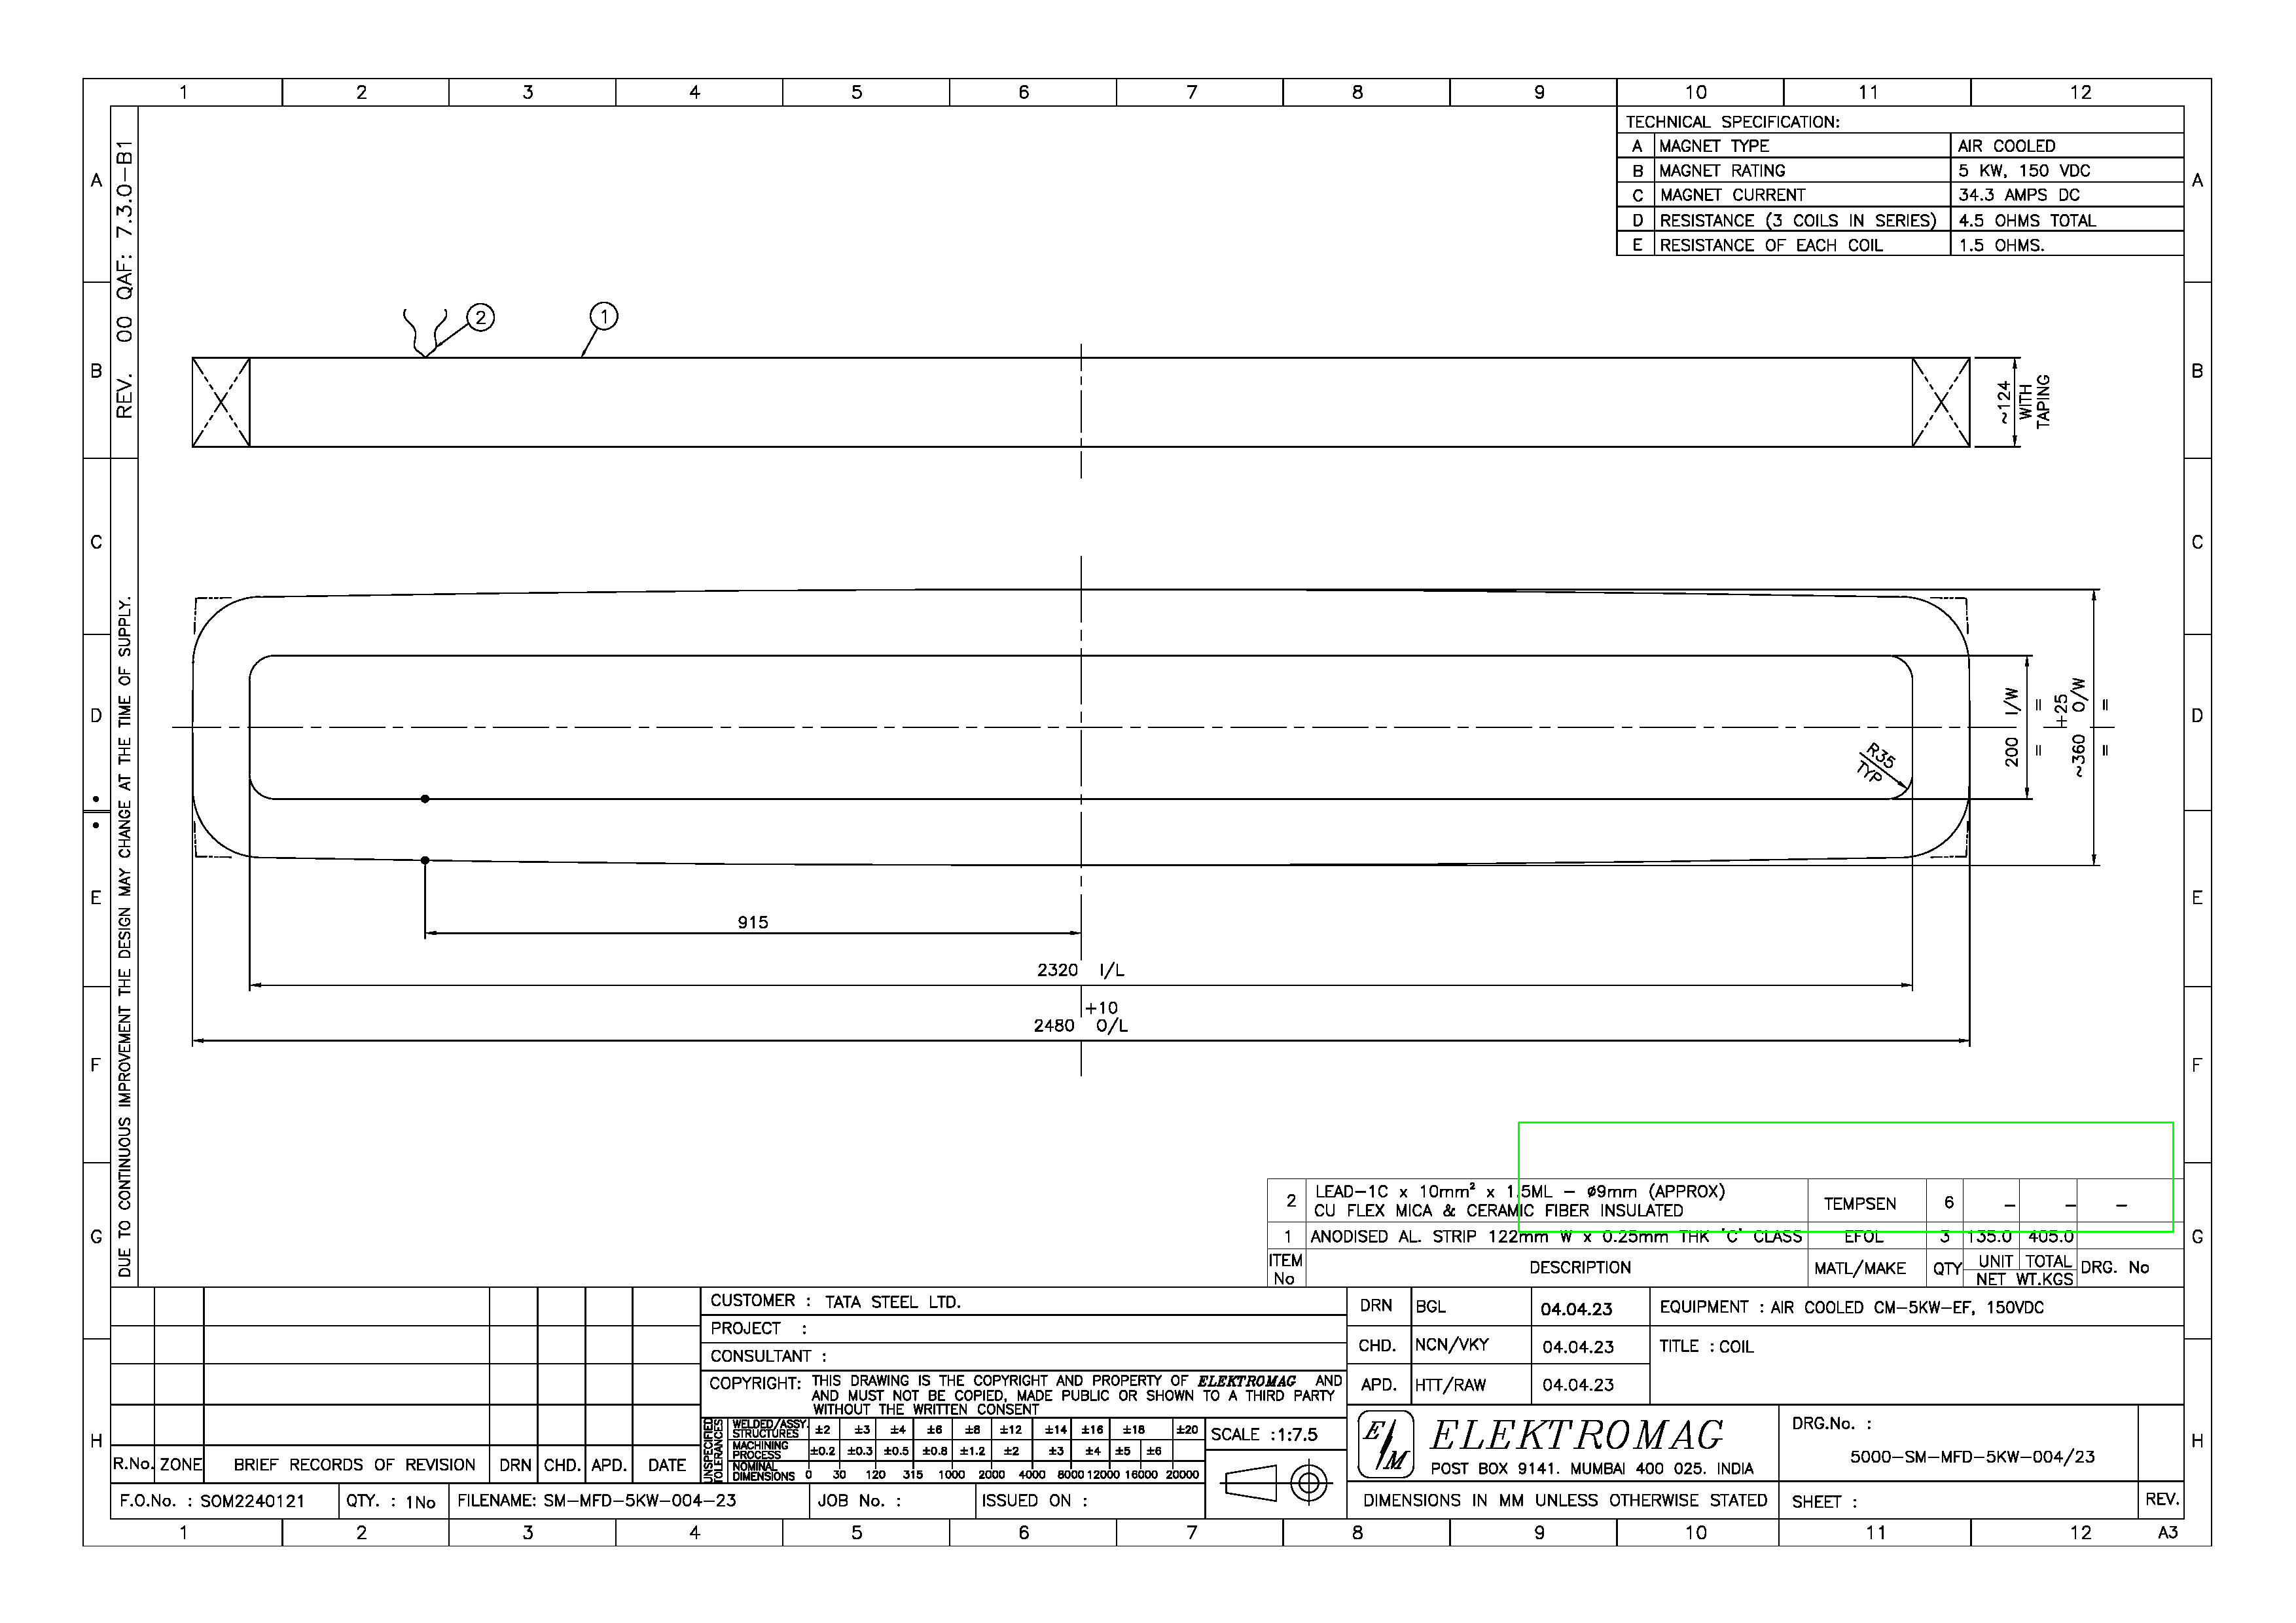

In [391]:
i = 2

x_path = test_image_line[i][1]
x = cv2.imread(x_path[0])

input_test = np.expand_dims(X_test[i], axis=0)
y_pred = model_new_1.predict(input_test)[0]

# Extract the predicted bounding box coordinates
x_min_pred_test = int(y_pred[0] * test_image_width[i])
y_min_pred_test = int(y_pred[1] * test_image_height[i])
x_max_pred_test = int(y_pred[2] * test_image_width[i])
y_max_pred_test = int(y_pred[3] * test_image_height[i])

x_min_actual_test = int(test_image_line[i][2][0][0])
y_min_actual_test = int(test_image_line[i][2][0][1])
x_max_actual_test = int(test_image_line[i][2][0][2])
y_max_actual_test = int(test_image_line[i][2][0][3])

#cv2.rectangle(x, (x_min_actual_test, y_min_actual_test), (x_max_actual_test, y_max_actual_test), (255, 0, 0), 2)
cv2.rectangle(x, (x_min_pred_test, y_min_pred_test), (x_max_pred_test, y_max_pred_test), (0, 255, 0), 2)

x_pil = Image.fromarray(x)
display(x_pil)



In [394]:
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[608, 608, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(128, activation = 'relu')(x)
x = Dense(4, activation = 'linear')(x)
model_new_2 = Model(vgg.input, x)
#model1.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
# plot the model
#plot_model(model1, "first_model.png",show_shapes=True,expand_nested=False)
print(model_new_2.summary())

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 608, 608, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 608, 608, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 608, 608, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 304, 304, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 304, 304, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 304, 304, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 152, 152, 128)     0  

In [395]:
epoch = 15
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model_new_2.compile(optimizer= opt, loss = 'mse')

history = model_new_2.fit(X_train,Y_train, epochs=epoch, batch_size = 8, validation_data=(X_val,Y_val))

Epoch 1/15
106/106 [==============================] - 3693s 35s/step - loss: 0.0924 - val_loss: 0.0046
Epoch 2/15
106/106 [==============================] - 3379s 32s/step - loss: 2.2700e-04 - val_loss: 0.0062
Epoch 3/15
106/106 [==============================] - 7989s 76s/step - loss: 1.3628e-04 - val_loss: 0.0049
Epoch 4/15
106/106 [==============================] - 3809s 36s/step - loss: 1.2846e-04 - val_loss: 0.0052
Epoch 5/15
106/106 [==============================] - 3610s 34s/step - loss: 6.9891e-05 - val_loss: 0.0048
Epoch 6/15
106/106 [==============================] - 3436s 32s/step - loss: 7.1097e-05 - val_loss: 0.0049
Epoch 7/15
106/106 [==============================] - 3424s 32s/step - loss: 5.2022e-05 - val_loss: 0.0048
Epoch 8/15
106/106 [==============================] - 3487s 33s/step - loss: 5.0913e-05 - val_loss: 0.0046
Epoch 9/15
106/106 [==============================] - 3578s 34s/step - loss: 4.9961e-05 - val_loss: 0.0048
Epoch 10/15
  6/106 [>...................

KeyboardInterrupt: 

In [402]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x


In [434]:
def make_yolov3_model_drop():
    input_image = Input(shape=(608, 608, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    x = Dropout(0.2)(x)
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    x = Dropout(0.2)(x)
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    
    input_image = Input(shape=(608, 608, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    x = Dropout(0.2)(x)
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    
    x = Dropout(0.2)(x)
    
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 3, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 36}], skip = False)
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 37}], skip = False)
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38}], skip = False)
    

    x = Flatten()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(4, activation = 'linear')(x)

    model = Model(input_image, x)
    return model

In [435]:
input_size = (target_w, target_h, 3)

my_model_1 = make_model_1()

print(my_model_1.summary())

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 608, 608, 32  864         ['input_29[0][0]']               
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 608, 608, 32  128         ['conv_0[0][0]']                 
                                )                                                          

In [436]:
epoch = 10
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

my_model_1.compile(optimizer= opt, loss = 'mse')

history = my_model_1.fit(X_train,Y_train, epochs=epoch, batch_size = 8, validation_data=(X_val,Y_val))

Epoch 1/10
106/106 [==============================] - 1222s 12s/step - loss: 0.3849 - val_loss: 0.1249
Epoch 2/10
106/106 [==============================] - 1344s 13s/step - loss: 0.0180 - val_loss: 0.0222
Epoch 3/10
106/106 [==============================] - 1296s 12s/step - loss: 0.0195 - val_loss: 0.0184
Epoch 4/10
106/106 [==============================] - 1267s 12s/step - loss: 0.0163 - val_loss: 0.0076
Epoch 5/10
106/106 [==============================] - 1299s 12s/step - loss: 0.0158 - val_loss: 0.0048
Epoch 6/10
106/106 [==============================] - 1187s 11s/step - loss: 0.0136 - val_loss: 0.0098
Epoch 7/10
106/106 [==============================] - 1193s 11s/step - loss: 0.0130 - val_loss: 0.0058
Epoch 8/10
106/106 [==============================] - 1216s 11s/step - loss: 0.0112 - val_loss: 0.0052
Epoch 9/10
106/106 [==============================] - 1603s 15s/step - loss: 0.0094 - val_loss: 0.0034
Epoch 10/10
106/106 [==============================] - 1360s 13s/step - l

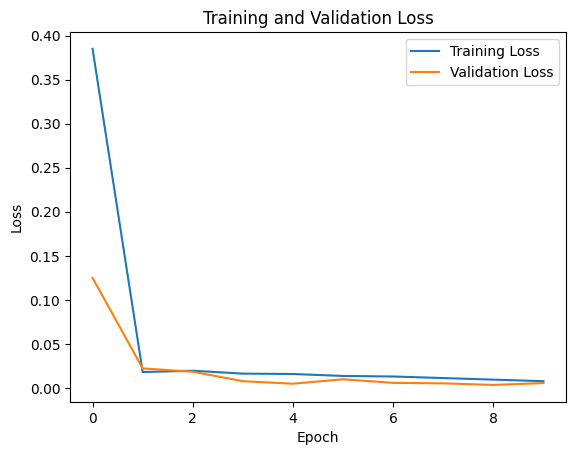

In [437]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [438]:
for i in range(len(test_image_line)):
               
    input_test = np.expand_dims(X_test[i], axis=0)
    y_pred = my_model_1.predict(input_test)[0]
# print(y_pred_same)

# Extract the predicted bounding box coordinates
    x_min_test = int(y_pred[0] * test_image_width[i])
    y_min_test = int(y_pred[1] * test_image_height[i])
    x_max_test = int(y_pred[2] * test_image_width[i])
    y_max_test = int(y_pred[3] * test_image_height[i])

# Print the predicted bounding box coordinates
    print('Predicted bounding box coordinates: ({}, {}, {}, {})'.format(x_min_test, y_min_test, x_max_test, y_max_test))

    print('Actual bounding box coordinates :', test_image_line[i][2])

    print('=====================================================')

1/1 [==============================] - 1s 556ms/step
Predicted bounding box coordinates: (2875, 1818, 3161, 1678)
Actual bounding box coordinates : [[2014. 1412. 3474. 2031.]]
1/1 [==============================] - 0s 203ms/step
Predicted bounding box coordinates: (2743, 1887, 3252, 1718)
Actual bounding box coordinates : [[2007. 1629. 3470. 2033.]]
1/1 [==============================] - 0s 201ms/step
Predicted bounding box coordinates: (2432, 1645, 3170, 1793)
Actual bounding box coordinates : [[1923. 1789. 3348. 1975.]]
1/1 [==============================] - 0s 199ms/step
Predicted bounding box coordinates: (2516, 1700, 3089, 1687)
Actual bounding box coordinates : [[1908. 1812. 3351. 1972.]]
1/1 [==============================] - 0s 194ms/step
Predicted bounding box coordinates: (2450, 1616, 2998, 1657)
Actual bounding box coordinates : [[1911. 1771. 3348. 1972.]]
1/1 [==============================] - 0s 196ms/step
Predicted bounding box coordinates: (2630, 1823, 3450, 1933)
Actual

In [439]:
history = my_model_1.fit(X_train,Y_train, epochs=20, batch_size = 8, validation_data=(X_val,Y_val))

Epoch 1/20
106/106 [==============================] - 1174s 11s/step - loss: 0.0074 - val_loss: 0.0026
Epoch 2/20
106/106 [==============================] - 1211s 11s/step - loss: 0.0072 - val_loss: 0.0027
Epoch 3/20
106/106 [==============================] - 1179s 11s/step - loss: 0.0076 - val_loss: 0.0155
Epoch 4/20
106/106 [==============================] - 1201s 11s/step - loss: 0.0072 - val_loss: 0.0071
Epoch 5/20
106/106 [==============================] - 1164s 11s/step - loss: 0.0069 - val_loss: 0.0112
Epoch 6/20
106/106 [==============================] - 1162s 11s/step - loss: 0.0051 - val_loss: 0.0125
Epoch 7/20
106/106 [==============================] - 1171s 11s/step - loss: 0.0056 - val_loss: 0.0064
Epoch 8/20
106/106 [==============================] - 1165s 11s/step - loss: 0.0049 - val_loss: 0.0084
Epoch 9/20
106/106 [==============================] - 2098s 20s/step - loss: 0.0053 - val_loss: 0.0018
Epoch 10/20
106/106 [==============================] - 1475s 14s/step - l

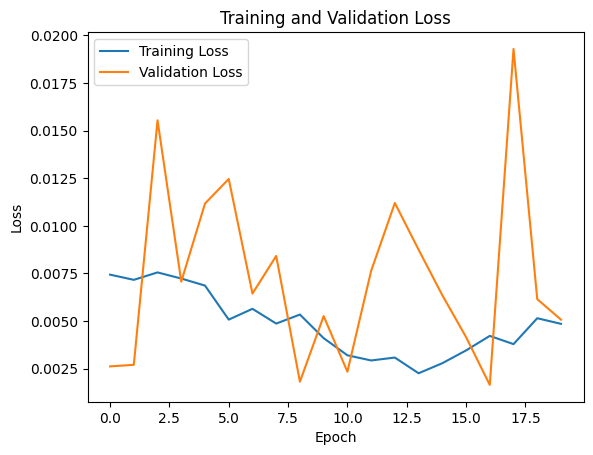

In [440]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [441]:
epoch = 30
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

my_model_1.compile(optimizer= opt, loss = 'mse')

history = my_model_1.fit(X_train,Y_train, epochs=epoch, batch_size = 12, validation_data=(X_val,Y_val))

Epoch 1/30
71/71 [==============================] - 1471s 21s/step - loss: 0.0013 - val_loss: 0.0052
Epoch 2/30
71/71 [==============================] - 2022s 29s/step - loss: 7.9852e-04 - val_loss: 0.0046
Epoch 3/30
71/71 [==============================] - 1594s 22s/step - loss: 6.4794e-04 - val_loss: 0.0043
Epoch 4/30
71/71 [==============================] - 1352s 19s/step - loss: 6.9067e-04 - val_loss: 0.0045
Epoch 5/30
71/71 [==============================] - 1366s 19s/step - loss: 6.0912e-04 - val_loss: 0.0039
Epoch 6/30
71/71 [==============================] - 1383s 19s/step - loss: 6.3263e-04 - val_loss: 0.0062
Epoch 7/30
71/71 [==============================] - 1378s 19s/step - loss: 4.2774e-04 - val_loss: 0.0042
Epoch 8/30
71/71 [==============================] - 1347s 19s/step - loss: 4.2431e-04 - val_loss: 0.0039
Epoch 9/30
71/71 [==============================] - 1345s 19s/step - loss: 3.6561e-04 - val_loss: 0.0037
Epoch 10/30
71/71 [==============================] - 1354s 

KeyboardInterrupt: 

In [447]:
def make_model_2():
    input_image = Input(shape=(608, 608, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    x = Dropout(0.2)(x)
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    x = Dropout(0.2)(x)

    """
    # Layer 16 => 36
    for i in range(2):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    """  
      
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 36}], skip = False)
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 37}], skip = False)
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38}], skip = False)
    

    x = Flatten()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(4, activation = 'linear')(x)

    model = Model(input_image, x)
    return model

In [448]:
input_size = (target_w, target_h, 3)

my_model_2 = make_model_2()

print(my_model_2.summary())

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 608, 608, 32  864         ['input_32[0][0]']               
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 608, 608, 32  128         ['conv_0[0][0]']                 
                                )                                                          

In [449]:
epoch = 25
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

my_model_2.compile(optimizer= opt, loss = 'mse')

history = my_model_2.fit(X_train,Y_train, epochs=epoch, batch_size = 12, validation_data=(X_val,Y_val))

Epoch 1/25
71/71 [==============================] - 809s 11s/step - loss: 0.2287 - val_loss: 0.2520
Epoch 2/25
71/71 [==============================] - 830s 12s/step - loss: 0.0461 - val_loss: 0.0546
Epoch 3/25
71/71 [==============================] - 834s 12s/step - loss: 0.0319 - val_loss: 0.0219
Epoch 4/25
71/71 [==============================] - 830s 12s/step - loss: 0.0277 - val_loss: 0.0073
Epoch 5/25
71/71 [==============================] - 825s 12s/step - loss: 0.0232 - val_loss: 0.0058
Epoch 6/25
71/71 [==============================] - 834s 12s/step - loss: 0.0210 - val_loss: 0.0081
Epoch 7/25
71/71 [==============================] - 831s 12s/step - loss: 0.0212 - val_loss: 0.0096
Epoch 8/25
71/71 [==============================] - 832s 12s/step - loss: 0.0210 - val_loss: 0.0099
Epoch 9/25
71/71 [==============================] - 833s 12s/step - loss: 0.0188 - val_loss: 0.0089
Epoch 10/25
71/71 [==============================] - 837s 12s/step - loss: 0.0192 - val_loss: 0.0142

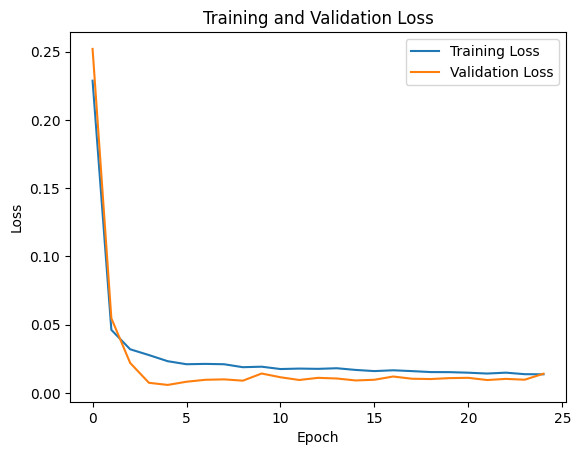

In [450]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [489]:
def make_model_3():
    input_image = Input(shape=(608, 608, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    x = Dropout(0.2)(x)

    
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    x = Dropout(0.2)(x)
    """
    # Layer 16 => 36
    for i in range(2):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    """  
      
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 36}], skip = False)
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 37}], skip = False)
    # x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38}], skip = False)
    

    x = Flatten()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(4, activation = 'linear')(x)

    model = Model(input_image, x)
    return model

In [490]:
input_size = (target_w, target_h, 3)

my_model_3 = make_model_3()

print(my_model_3.summary())

Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 608, 608, 32  864         ['input_45[0][0]']               
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 608, 608, 32  128         ['conv_0[0][0]']                 
                                )                                                          

In [467]:
epoch = 25
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

my_model_2.compile(optimizer= opt, loss = 'mse')

history = my_model_2.fit(X_train,Y_train, epochs=epoch, batch_size = 12, validation_data=(X_val,Y_val))

Epoch 1/25
71/71 [==============================] - 793s 11s/step - loss: 0.0130 - val_loss: 0.0083
Epoch 2/25
71/71 [==============================] - 844s 12s/step - loss: 0.0128 - val_loss: 0.0088
Epoch 3/25
71/71 [==============================] - 871s 12s/step - loss: 0.0130 - val_loss: 0.0078
Epoch 4/25
71/71 [==============================] - 886s 12s/step - loss: 0.0115 - val_loss: 0.0082
Epoch 5/25
71/71 [==============================] - 896s 13s/step - loss: 0.0118 - val_loss: 0.0088
Epoch 6/25
71/71 [==============================] - 894s 13s/step - loss: 0.0106 - val_loss: 0.0082
Epoch 7/25
71/71 [==============================] - 889s 13s/step - loss: 0.0104 - val_loss: 0.0089
Epoch 8/25
71/71 [==============================] - 898s 13s/step - loss: 0.0100 - val_loss: 0.0073
Epoch 9/25
71/71 [==============================] - 908s 13s/step - loss: 0.0091 - val_loss: 0.0061
Epoch 10/25
71/71 [==============================] - 849s 12s/step - loss: 0.0087 - val_loss: 0.0081

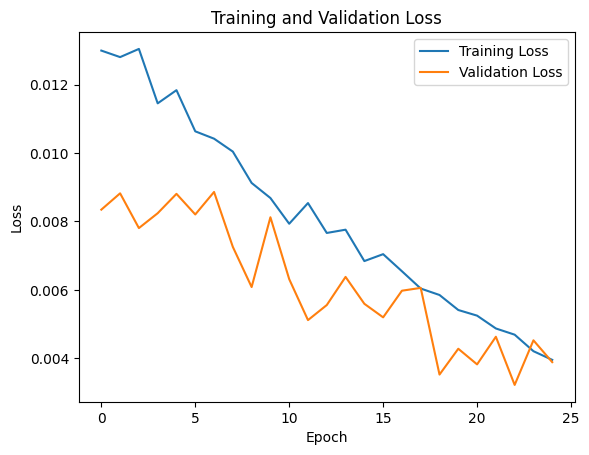

In [468]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [472]:
def make_model_4():
    input_image = Input(shape=(608, 608, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    x = Dropout(0.2)(x)
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    x = Dropout(0.2)(x)

    """
    # Layer 16 => 36
    for i in range(2):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    """  
      
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 36}], skip = False)
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 37}], skip = False)
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38}], skip = False)
    

    x = Flatten()(x)
    x = Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(0.01))(x)
    # x = Dense(128, activation = 'relu')(x)
    x = Dense(4, activation = 'linear')(x)

    model = Model(input_image, x)
    return model

In [473]:
input_size = (target_w, target_h, 3)

my_model_4 = make_model_4()

print(my_model_4.summary())

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 608, 608, 32  864         ['input_41[0][0]']               
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 608, 608, 32  128         ['conv_0[0][0]']                 
                                )                                                          

In [474]:
epoch = 25
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

my_model_2.compile(optimizer= opt, loss = 'mse')

history = my_model_2.fit(X_train,Y_train, epochs=epoch, batch_size = 12, validation_data=(X_val,Y_val))

Epoch 1/25
71/71 [==============================] - 836s 12s/step - loss: 0.0042 - val_loss: 0.0056
Epoch 2/25
71/71 [==============================] - 846s 12s/step - loss: 0.0037 - val_loss: 0.0058
Epoch 3/25
71/71 [==============================] - 867s 12s/step - loss: 0.0036 - val_loss: 0.0029
Epoch 4/25
71/71 [==============================] - 902s 13s/step - loss: 0.0032 - val_loss: 0.0028
Epoch 5/25
71/71 [==============================] - 890s 13s/step - loss: 0.0029 - val_loss: 0.0052
Epoch 6/25
71/71 [==============================] - 885s 12s/step - loss: 0.0027 - val_loss: 0.0072
Epoch 7/25
71/71 [==============================] - 944s 13s/step - loss: 0.0028 - val_loss: 0.0036
Epoch 8/25
71/71 [==============================] - 966s 14s/step - loss: 0.0022 - val_loss: 0.0054
Epoch 9/25
71/71 [==============================] - 985s 14s/step - loss: 0.0024 - val_loss: 0.0036
Epoch 10/25
71/71 [==============================] - 989s 14s/step - loss: 0.0023 - val_loss: 0.0046

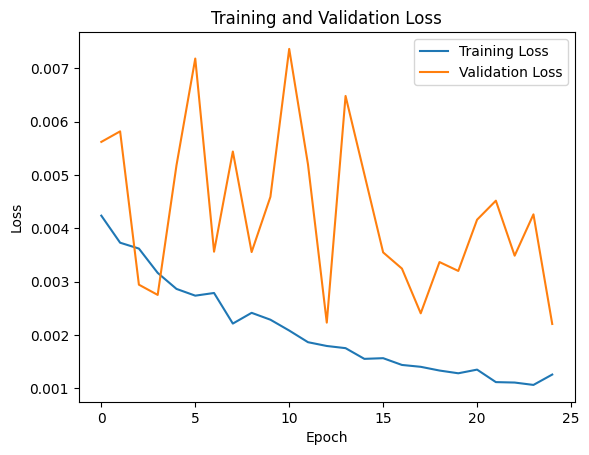

In [475]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [480]:
epoch = 25
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

my_model_3.compile(optimizer= opt, loss = 'mse')

history = my_model_3.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/25
53/53 [==============================] - 876s 17s/step - loss: 0.2852 - val_loss: 0.2479
Epoch 2/25
53/53 [==============================] - 985s 19s/step - loss: 0.0543 - val_loss: 0.1059
Epoch 3/25
53/53 [==============================] - 1112s 21s/step - loss: 0.0384 - val_loss: 0.0466
Epoch 4/25
53/53 [==============================] - 1159s 22s/step - loss: 0.0345 - val_loss: 0.0255
Epoch 5/25
53/53 [==============================] - 1093s 21s/step - loss: 0.0329 - val_loss: 0.0110
Epoch 6/25
53/53 [==============================] - 885s 17s/step - loss: 0.0294 - val_loss: 0.0074
Epoch 7/25
53/53 [==============================] - 890s 17s/step - loss: 0.0293 - val_loss: 0.0048
Epoch 8/25
53/53 [==============================] - 884s 17s/step - loss: 0.0283 - val_loss: 0.0054
Epoch 9/25
53/53 [==============================] - 885s 17s/step - loss: 0.0271 - val_loss: 0.0072
Epoch 10/25
53/53 [==============================] - 885s 17s/step - loss: 0.0269 - val_loss: 0.0

<function matplotlib.pyplot.show(close=None, block=None)>

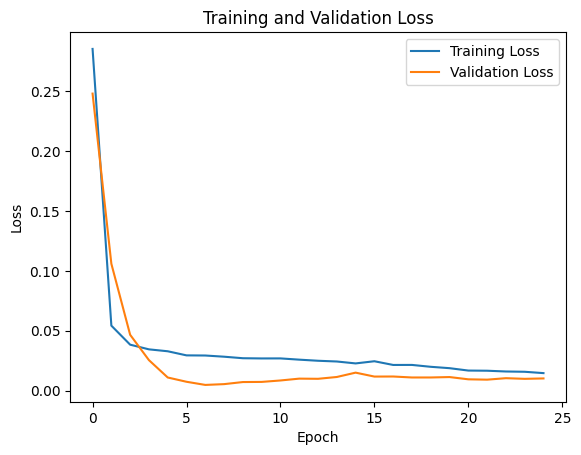

In [481]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

In [487]:
opt= RMSprop(learning_rate=0.00001, rho=0.9)

epoch = 25
# opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

my_model_3.compile(optimizer= opt, loss = 'mse')

history = my_model_3.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/25
53/53 [==============================] - 972s 18s/step - loss: 0.2653 - val_loss: 0.1703
Epoch 2/25
53/53 [==============================] - 1187s 22s/step - loss: 0.0391 - val_loss: 0.0451
Epoch 3/25
53/53 [==============================] - 1187s 22s/step - loss: 0.0244 - val_loss: 0.0104
Epoch 4/25
53/53 [==============================] - 1194s 23s/step - loss: 0.0205 - val_loss: 0.0178
Epoch 5/25
53/53 [==============================] - 1175s 22s/step - loss: 0.0186 - val_loss: 0.0053
Epoch 6/25
53/53 [==============================] - 1076s 20s/step - loss: 0.0159 - val_loss: 0.0067
Epoch 7/25
53/53 [==============================] - 879s 17s/step - loss: 0.0159 - val_loss: 0.0067
Epoch 8/25
53/53 [==============================] - 887s 17s/step - loss: 0.0148 - val_loss: 0.0080
Epoch 9/25
53/53 [==============================] - 907s 17s/step - loss: 0.0142 - val_loss: 0.0076
Epoch 10/25
53/53 [==============================] - 917s 17s/step - loss: 0.0132 - val_loss: 0

<function matplotlib.pyplot.show(close=None, block=None)>

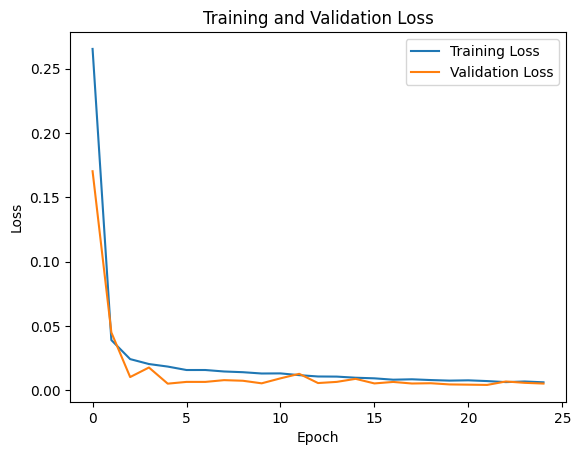

In [488]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

In [491]:
# opt= RMSprop(learning_rate=0.00001, rho=0.9)
opt= SGD(learning_rate=0.00001)


epoch = 25
# opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

my_model_3.compile(optimizer= opt, loss = 'mse')

history = my_model_3.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/25
53/53 [==============================] - 873s 16s/step - loss: 0.5459 - val_loss: 0.3543
Epoch 2/25
53/53 [==============================] - 919s 17s/step - loss: 0.4478 - val_loss: 0.2459
Epoch 3/25
53/53 [==============================] - 1064s 20s/step - loss: 0.4394 - val_loss: 0.1827
Epoch 4/25
53/53 [==============================] - 1146s 22s/step - loss: 0.4157 - val_loss: 0.1484
Epoch 5/25
53/53 [==============================] - 1145s 22s/step - loss: 0.3903 - val_loss: 0.1372
Epoch 6/25
53/53 [==============================] - 1122s 21s/step - loss: 0.3775 - val_loss: 0.1362
Epoch 7/25
53/53 [==============================] - 1069s 20s/step - loss: 0.3683 - val_loss: 0.1432
Epoch 8/25
53/53 [==============================] - 1092s 21s/step - loss: 0.3540 - val_loss: 0.1490
Epoch 9/25
53/53 [==============================] - 1099s 21s/step - loss: 0.3549 - val_loss: 0.1537
Epoch 10/25
53/53 [==============================] - 1085s 20s/step - loss: 0.3258 - val_loss

<function matplotlib.pyplot.show(close=None, block=None)>

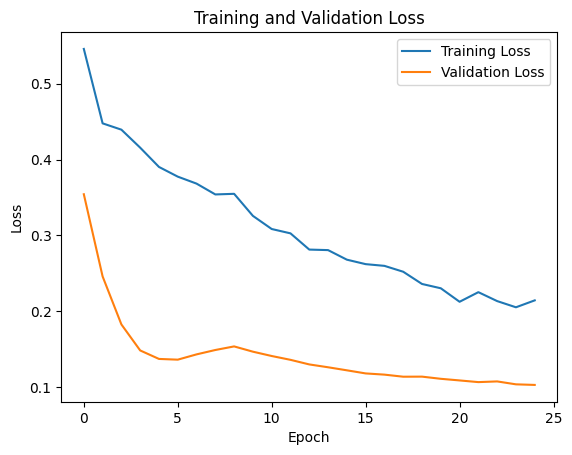

In [492]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

In [493]:
# opt= RMSprop(learning_rate=0.00001, rho=0.9)
opt= SGD(learning_rate=0.00001)


epoch = 30
# opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

my_model_3.compile(optimizer= opt, loss = 'mse')

history = my_model_3.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/30
53/53 [==============================] - 865s 16s/step - loss: 0.1882 - val_loss: 0.1006
Epoch 2/30
53/53 [==============================] - 870s 16s/step - loss: 0.1884 - val_loss: 0.1006
Epoch 3/30
53/53 [==============================] - 866s 16s/step - loss: 0.2036 - val_loss: 0.0987
Epoch 4/30
53/53 [==============================] - 867s 16s/step - loss: 0.1835 - val_loss: 0.0971
Epoch 5/30
53/53 [==============================] - 869s 16s/step - loss: 0.1752 - val_loss: 0.0943
Epoch 6/30
53/53 [==============================] - 873s 16s/step - loss: 0.1784 - val_loss: 0.0936
Epoch 7/30
53/53 [==============================] - 869s 16s/step - loss: 0.1783 - val_loss: 0.0922
Epoch 8/30
53/53 [==============================] - 871s 16s/step - loss: 0.1700 - val_loss: 0.0906
Epoch 9/30
53/53 [==============================] - 870s 16s/step - loss: 0.1627 - val_loss: 0.0891
Epoch 10/30
53/53 [==============================] - 870s 16s/step - loss: 0.1603 - val_loss: 0.0885

<function matplotlib.pyplot.show(close=None, block=None)>

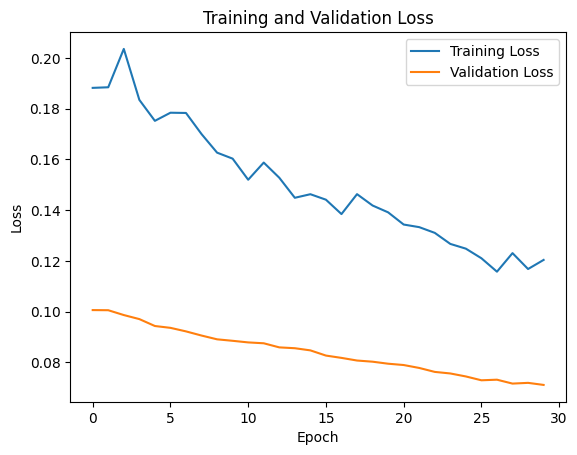

In [494]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

In [496]:
epoch = 50
history = my_model_3.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/50
53/53 [==============================] - 905s 17s/step - loss: 0.1095 - val_loss: 0.0698
Epoch 2/50
53/53 [==============================] - 996s 19s/step - loss: 0.1134 - val_loss: 0.0695
Epoch 3/50
53/53 [==============================] - 902s 17s/step - loss: 0.1110 - val_loss: 0.0680
Epoch 4/50
53/53 [==============================] - 905s 17s/step - loss: 0.1115 - val_loss: 0.0672
Epoch 5/50
53/53 [==============================] - 942s 18s/step - loss: 0.1087 - val_loss: 0.0669
Epoch 6/50
53/53 [==============================] - 938s 18s/step - loss: 0.1055 - val_loss: 0.0658
Epoch 7/50
53/53 [==============================] - 923s 17s/step - loss: 0.1060 - val_loss: 0.0654
Epoch 8/50
53/53 [==============================] - 902s 17s/step - loss: 0.0998 - val_loss: 0.0653
Epoch 9/50
53/53 [==============================] - 892s 17s/step - loss: 0.0973 - val_loss: 0.0645
Epoch 10/50
53/53 [==============================] - 879s 17s/step - loss: 0.1031 - val_loss: 0.0636

<function matplotlib.pyplot.show(close=None, block=None)>

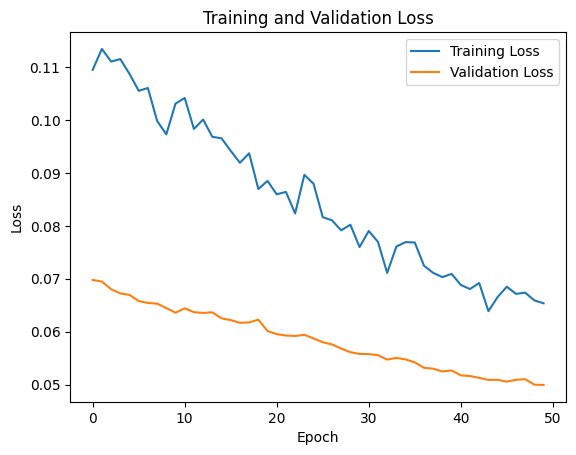

In [497]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

In [499]:
for i in range(len(test_image_line)):
               
    input_test = np.expand_dims(X_test[i], axis=0)
    y_pred = my_model_3.predict(input_test)[0]
# print(y_pred_same)

# Extract the predicted bounding box coordinates
    x_min_test = int(y_pred[0] * test_image_width[i])
    y_min_test = int(y_pred[1] * test_image_height[i])
    x_max_test = int(y_pred[2] * test_image_width[i])
    y_max_test = int(y_pred[3] * test_image_height[i])

# Print the predicted bounding box coordinates
    print('Predicted bounding box coordinates: ({}, {}, {}, {})'.format(x_min_test, y_min_test, x_max_test, y_max_test))

    print('Actual bounding box coordinates :', test_image_line[i][2])

    print('=====================================================')

1/1 [==============================] - 0s 277ms/step
Predicted bounding box coordinates: (1841, 1195, 2937, 1516)
Actual bounding box coordinates : [[2014. 1412. 3474. 2031.]]
1/1 [==============================] - 0s 114ms/step
Predicted bounding box coordinates: (2201, 782, 2050, 1554)
Actual bounding box coordinates : [[2007. 1629. 3470. 2033.]]
1/1 [==============================] - 0s 117ms/step
Predicted bounding box coordinates: (1689, 1484, 1425, 1632)
Actual bounding box coordinates : [[1923. 1789. 3348. 1975.]]
1/1 [==============================] - 0s 119ms/step
Predicted bounding box coordinates: (2012, 1247, 2134, 1561)
Actual bounding box coordinates : [[1908. 1812. 3351. 1972.]]
1/1 [==============================] - 0s 120ms/step
Predicted bounding box coordinates: (2217, 1443, 2330, 1498)
Actual bounding box coordinates : [[1911. 1771. 3348. 1972.]]
1/1 [==============================] - 0s 117ms/step
Predicted bounding box coordinates: (1520, 791, 2591, 1156)
Actual b

In [500]:
epoch = 50
history = my_model_3.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/50
53/53 [==============================] - 861s 16s/step - loss: 0.0671 - val_loss: 0.0494
Epoch 2/50
53/53 [==============================] - 860s 16s/step - loss: 0.0631 - val_loss: 0.0489
Epoch 3/50
53/53 [==============================] - 861s 16s/step - loss: 0.0604 - val_loss: 0.0483
Epoch 4/50
53/53 [==============================] - 876s 17s/step - loss: 0.0641 - val_loss: 0.0477
Epoch 5/50
53/53 [==============================] - 870s 16s/step - loss: 0.0632 - val_loss: 0.0476
Epoch 6/50
53/53 [==============================] - 874s 17s/step - loss: 0.0642 - val_loss: 0.0480
Epoch 7/50
53/53 [==============================] - 885s 17s/step - loss: 0.0616 - val_loss: 0.0472
Epoch 8/50
53/53 [==============================] - 914s 17s/step - loss: 0.0600 - val_loss: 0.0467
Epoch 9/50
53/53 [==============================] - 918s 17s/step - loss: 0.0595 - val_loss: 0.0465
Epoch 10/50
53/53 [==============================] - 963s 18s/step - loss: 0.0581 - val_loss: 0.0466

KeyboardInterrupt: 

In [ ]:
# Classification and localisation loss :
# y_true in shape (xmin, ymin, xmax, ymax, class probability)

def localization_loss(y_true, y_pred):
    # Extract the true bounding box coordinates
    true_bbox = y_true[:, :4]
    
    # Extract the predicted bounding box coordinates
    pred_bbox = y_pred[:, :4]
    
    # Compute the mean squared error (MSE) loss for localization
    loc_loss = tf.reduce_mean(tf.square(true_bbox - pred_bbox))
    
    return loc_loss

def classification_loss(y_true, y_pred):
    # Extract the true class labels
    true_labels = y_true[:, 4:]
    
    # Extract the predicted class probabilities
    pred_probs = y_pred[:, 4:]
    
    # Compute the binary cross-entropy loss for classification
    class_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(true_labels, pred_probs))
    
    return class_loss

def total_loss(y_true, y_pred):
    # Compute the total loss as a combination of localization and classification losses
    loc_loss = localization_loss(y_true, y_pred)
    class_loss = classification_loss(y_true, y_pred)
    total_loss = loc_loss + class_loss
    
    return loss